# Magnetic vector inversion (MVI) on a 3D TreeMesh

In [70]:
# In this example, we demonstrate the use of a Magnetic Vector Inverison
# on a tiled 3D TreeMesh for the inversion of magnetic data.
# The inverse problem uses the :class:'SimPEG.regularization.VectorAmplitude'
# and the :class:'SimPEG.meta.multiprocessing.MultiprocessingMetaSimulation' which has not been merged into 
# the main branch yet.

## Load the required packages for this example

In [71]:
# Make sure that we are using the correct versions of discretize and SimPEG 
# Discretize (0.9.0)
# SimPEG (0.20.0 with MultiprocessingMetaSimulation class)
import sys

# Using the standard conda version of discretize
import discretize
print(discretize.__version__)
print(discretize.__path__)

# Make sure that we are using a branch of SimPEG with the MultiprocessingMetaSimulation class  
sys.path.insert(1,'C://Users//mamitchell//git//simpeg_micmitch//')
import SimPEG
print(SimPEG.__version__)
print(SimPEG.__path__)

print(sys.path)

0.9.0
['C:\\Users\\mamitchell\\Anaconda3\\envs\\simpeg_main\\lib\\site-packages\\discretize']
0.20.1.dev29+g44c4a61f4
['C:\\/Users//mamitchell//git//simpeg_micmitch\\SimPEG']
['C:\\Users\\mamitchell\\OneDrive - DOI\\CLVF\\Magnetics\\SingleBlk_Test\\Tiled\\Tiled_MVI_2BlockExample', 'C://Users//mamitchell//git//simpeg_micmitch//', 'C://Users//mamitchell//git//simpeg_micmitch//', 'C:\\Users\\mamitchell\\Anaconda3\\envs\\simpeg_main\\python38.zip', 'C:\\Users\\mamitchell\\Anaconda3\\envs\\simpeg_main\\DLLs', 'C:\\Users\\mamitchell\\Anaconda3\\envs\\simpeg_main\\lib', 'C:\\Users\\mamitchell\\Anaconda3\\envs\\simpeg_main', '', 'C:\\Users\\mamitchell\\Anaconda3\\envs\\simpeg_main\\lib\\site-packages', 'c:\\users\\mamitchell\\git\\simpeg\\discretize', 'C:\\Users\\mamitchell\\Anaconda3\\envs\\simpeg_main\\lib\\site-packages\\empymod-2.2.1-py3.9.egg', 'C:\\Users\\mamitchell\\Anaconda3\\envs\\simpeg_main\\lib\\site-packages\\geoana-0.4.0-py3.9.egg', 'C:\\Users\\mamitchell\\Anaconda3\\envs\\simpeg

In [1]:
from discretize import TreeMesh
from SimPEG import (
    data,
    data_misfit,
    directives,
    maps,
    inverse_problem,
    optimization,
    inversion,
    regularization,
)

# from SimPEG.meta.dask_sim import DaskMetaSimulation
from SimPEG.meta.multiprocessing import MultiprocessingMetaSimulation

from SimPEG import utils
from SimPEG.utils import mkvc, sdiag

from discretize.utils import mesh_builder_xyz, refine_tree_xyz, active_from_xyz
from SimPEG.potential_fields import magnetics
import dask
import scipy as sp
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import matplotlib.pyplot as plt

%pylab inline
# %matplotlib inline
%matplotlib notebook
matplotlib.rcParams['font.size'] = 14

from IPython.display import Image

import time


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Define the amplitude, inclination, and declination of the inducing field ($B_0$)

In [4]:
# The amplitude, inclination, and declination of the inducing field B_0 will be used for defining the 
# source field later in the survey object.
B0_amp = 50000.0
B0_inc = 60.0
B0_dec = 15.0


## Create a synthetic topographic surface from 2 Gaussian functions

In [5]:
# Define limits of mesh core extending 600 m in each direction from the origin (0, 0)
meshCoreXmin = -600
meshCoreXmax = 600

meshCoreYmin = -600
meshCoreYmax = 600

# Create a 10 m grid covering the core region 
[xx, yy] = np.meshgrid(np.arange(meshCoreXmin, meshCoreXmax, 10), np.arange(meshCoreYmin, meshCoreYmax, 10))

# Use 2 Gaussian functions to create some synthetic topography
# Hill 1 parameters
b1 = 120
A1 = 200
x0_Hill1 = -200
y0_Hill1 = -140
zz1 = A1 * np.exp(-0.5 * (((xx - x0_Hill1)/ b1) ** 2.0 + ((yy - y0_Hill1)/ b1) ** 2.0))

# Hill 2 parameters
b2 = 200
A2 = 120
x0_Hill2 = 120
y0_Hill2 = 220
zz2 = A2 * np.exp(-0.5 * (((xx - x0_Hill2)/ b2) ** 2.0 + ((yy - y0_Hill2)/ b2) ** 2.0))

# Combine elevations from the 2 Gaussian functions at each grid location and set the max value as the topo elevation (zz) 
zz_combined = np.c_[utils.mkvc(zz1), utils.mkvc(zz2)]
zz = np.max(zz_combined, axis=1)

topo = np.c_[utils.mkvc(xx), utils.mkvc(yy), zz]

## Define measurement locations

In [6]:
# Create a 25 m grid of observation points extending 500 in x and y from the origin
xLocs = np.linspace(-500.0, 500.0, 25)
yLocs = np.linspace(-500.0, 500.0, 25)
X, Y = np.meshgrid(xLocs, yLocs)

# Unwrap grid values into a 1D array/vector
xRx = utils.mkvc(X)
yRx = utils.mkvc(Y)

# Create interpolation function for topography
topoInterp = sp.interpolate.LinearNDInterpolator(np.c_[topo[:,0], topo[:,1]], topo[:,2])

# Use the topo interpolation function to calculate the elevation at each observation point
# Here we are adding 10 m to each elevation to specify that the data height is 10 m above the topographic surface.
zRx = topoInterp(np.c_[xRx, yRx]) + 10

# Create xyz array of RX locations [nData,3]
xyzRxLoc = np.c_[xRx, yRx, zRx]

## Visualize the synthetic topography 

<IPython.core.display.Javascript object>


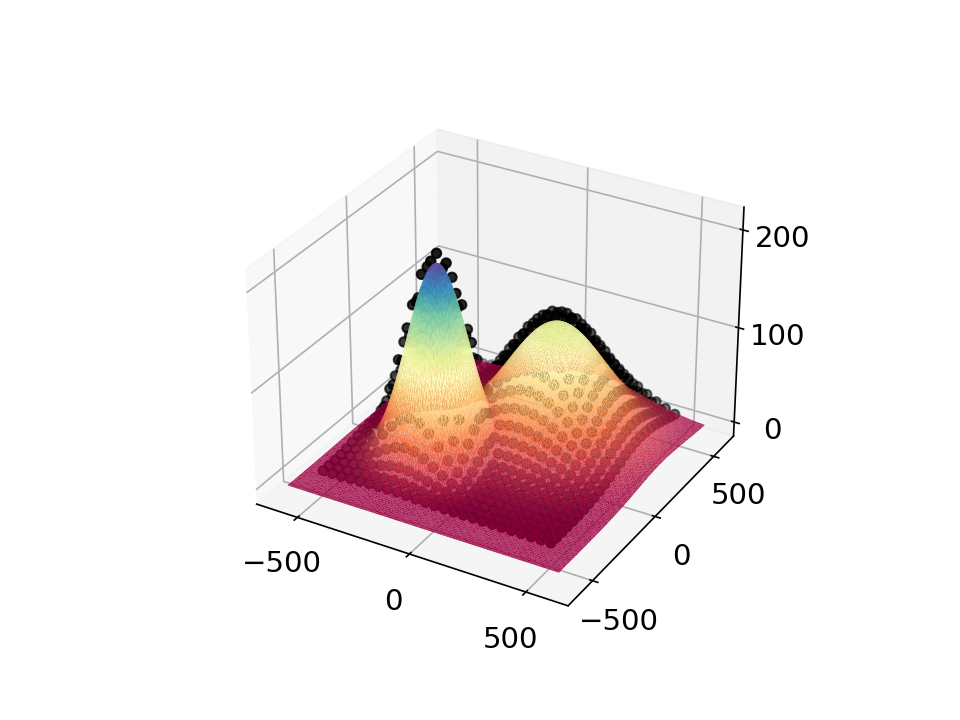

In [7]:
tri = sp.spatial.Delaunay(topo)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot_trisurf(
    topo[:, 0], topo[:, 1], topo[:, 2], triangles=tri.simplices, cmap=plt.cm.Spectral
)
ax.scatter3D(xyzRxLoc[:, 0], xyzRxLoc[:, 1], xyzRxLoc[:, 2], c="k")
plt.show()

# Create a global 3D tree mesh for the inversion

In [8]:
# Set smallest cell size (10 m cubes)
h = [10, 10, 10]

# Set padding distance for mesh to be 10 km in all directions
padDist = np.ones((3, 2)) * 10000

# Create basic tree mesh
mesh = mesh_builder_xyz(xyzRxLoc, h, padding_distance=padDist, depth_core=300, mesh_type="tree")

# Shift mesh origin so that y=0, x=0, and z=0 align with cell centers
print(mesh.x0)

xCellCentersInd = int(np.searchsorted(mesh.cell_centers_x, 0))
print('Nearest cell center to x=0:', mesh.cell_centers_x[xCellCentersInd])
xShift = -mesh.cell_centers_x[xCellCentersInd]
print(xShift)

yCellCentersInd = int(np.searchsorted(mesh.cell_centers_y, 0))
print('Nearest cell center to y=0:', mesh.cell_centers_y[yCellCentersInd])
yShift = -mesh.cell_centers_y[yCellCentersInd]
print(yShift)

zCellCentersInd = int(np.searchsorted(mesh.cell_centers_z, 0))
print('Nearest cell center to z=0:', mesh.cell_centers_z[zCellCentersInd])
zShift = -mesh.cell_centers_z[zCellCentersInd]
print(zShift)

mesh.x0 = mesh.x0 + np.array([xShift, yShift, zShift])

print(mesh.x0)

# Refine mesh cells with the core region
# Define corners of a box enclosing the core region (coreXYZ_1)
xp1, yp1, zp1 = np.meshgrid([meshCoreXmin, meshCoreXmax], [meshCoreYmin, meshCoreYmax],[-200, 200])
coreXYZ_1 = np.c_[utils.mkvc(xp1), utils.mkvc(yp1), utils.mkvc(zp1)]

# Refine core cells within the box to tree level -2 (one size large than the minimum cell size, in this case 20 m cubes)
mesh.refine_bounding_box(coreXYZ_1, level=-2, padding_cells_by_level=2, diagonal_balance=True, finalize=False)

# Discretize the topographic surface by refining the cells along the interface to the smallest cell size  
mesh.refine_surface(topo, level=-1, padding_cells_by_level=2, diagonal_balance=True, finalize=True)



[-20480.         -20480.         -20529.96972728]
Nearest cell center to x=0: 5.0
-5.0
Nearest cell center to y=0: 5.0
-5.0
Nearest cell center to z=0: 5.030272721356596
-5.030272721356596
[-20485. -20485. -20535.]


## Define active cells based on the topographic surface

In [9]:
#  Active cell are model cells below the topgraphic surface. Air cells, above topography, are set to inactive. 
# Only the physical properties of active cells can be changed by the inversion.
actCells = active_from_xyz(mesh, topo)

# Calculat the number of active cells in the inversion 
nActCells = int(actCells.sum())


# Create an projection matrix which maps the model from the active space the full model space for plotting later
actCellsMap = maps.InjectActiveCells(mesh, actCells, np.nan)


## To parallelize the problem split it into smaller pieces known as tiles

In [10]:
# Split the data set into two tiles along x=0 and create local meshes and surveys

# Define boundaries of the local meshes
xBoundary = 0
xCore_Overlap = 200
xTopo_Overlap = 200
localMeshCore_xMin = [-600, xBoundary - xCore_Overlap]
localMeshCore_xMax = [xBoundary + xCore_Overlap, 600]

localMeshCore_yMin = [-600, -600]
localMeshCore_yMax = [600, 600]

# Create local meshes and surveys for each tile
local_RxInds = [xyzRxLoc[:, 0] <= xBoundary, xyzRxLoc[:, 0] > xBoundary]
local_TopoInds = [topo[:, 0] <= xBoundary + xTopo_Overlap, topo[:, 0] > xBoundary - xTopo_Overlap]
local_surveys = []
local_meshes = []
local_actCells = []
local_nActCells = []
local_actCellMaps = []
for ii, local_RxInd in enumerate(local_RxInds):
    # Define receivers, in this case point measurements of the total magnetic intensity (TMI)
    receivers = magnetics.receivers.Point(xyzRxLoc[local_RxInd, :])
    # Define the source field using the azimuth, dip, and amplitude of the inducing field
    srcField = magnetics.sources.UniformBackgroundField(receiver_list=[receivers], amplitude=B0_amp, 
                                                        inclination=B0_inc, declination=B0_dec)
    # Create local survey object
    local_survey = magnetics.survey.Survey(srcField)
    print('nD in local survey:', local_survey.nD)

    # Create the local meshes 
    local_mesh = mesh_builder_xyz(xyzRxLoc, h, padding_distance=padDist, depth_core=300, mesh_type="tree")
    
    # Shift local mesh origin so that y=0, x=0, z=0 align with cell centers
    print(local_mesh.x0)
    
    xCellCenter_Ind = int(np.searchsorted(local_mesh.cell_centers_x, 0))
    print(local_mesh.cell_centers_x[xCellCenter_Ind])
    xShift =local_mesh.cell_centers_x[xCellCenter_Ind]
    print(xShift)
    
    yCellCenter_Ind = int(np.searchsorted(local_mesh.cell_centers_y, 0))
    print(local_mesh.cell_centers_y[yCellCenter_Ind])
    yShift = -local_mesh.cell_centers_y[yCellCenter_Ind]
    print(yShift)

    zCellCenter_Ind = int(np.searchsorted(local_mesh.cell_centers_z, 0))
    print(local_mesh.cell_centers_z[zCellCenter_Ind])
    zShift = -local_mesh.cell_centers_z[zCellCenter_Ind]
    print(zShift)

    local_mesh.x0 = local_mesh.x0 + np.array([xShift, yShift, zShift])

    print(local_mesh.x0)

    # Refine local mesh cells with the core region
    # Define corners of a box enclosing the core region (coreXYZ_1)
    xp1, yp1, zp1 = np.meshgrid([localMeshCore_xMin[ii], localMeshCore_xMax[ii]], [localMeshCore_yMin[ii], localMeshCore_yMax[ii]],[-200, 200])
    coreXYZ_1 = np.c_[utils.mkvc(xp1), utils.mkvc(yp1), utils.mkvc(zp1)]
    
    # Refine core cells within the box to tree level -2 (one size large than the minimum cell size, in this case 20 m cubes)
    local_mesh.refine_bounding_box(coreXYZ_1, level=-2, padding_cells_by_level=2, diagonal_balance=True, finalize=False)

    # Discretize the topographic surface by refining the cells along the interface to the smallest cell size
    local_mesh.refine_surface(topo[local_TopoInds[ii], :], level=-1, padding_cells_by_level=2, diagonal_balance=True, finalize=True)
    
    # Define active cells for each local mesh
    local_actCell = active_from_xyz(local_mesh, topo[local_TopoInds[ii], :])
    local_nActCell = int(local_actCell.sum())
    local_actCellMap = maps.InjectActiveCells(local_mesh, local_actCell, np.nan)

    # Append objects to a list for later access
    local_surveys.append(local_survey)
    local_meshes.append(local_mesh)
    local_actCells.append(local_actCell)
    local_nActCells.append(local_nActCell)
    local_actCellMaps.append(local_actCellMap)

nD in local survey: 325
[-20480.         -20480.         -20529.96972728]
5.0
5.0
5.0
-5.0
5.030272721356596
-5.030272721356596
[-20475. -20485. -20535.]
nD in local survey: 300
[-20480.         -20480.         -20529.96972728]
5.0
5.0
5.0
-5.0
5.030272721356596
-5.030272721356596
[-20475. -20485. -20535.]


## Plot global mesh sections

In [11]:
# fig = plt.figure()
# ax = plt.subplot(111)
# fig.set_figheight(10)
# fig.set_figwidth(10)

# zSliceInd = int(np.searchsorted(mesh.cell_centers_z, 20))
# mesh.plot_slice(actCells, ax=ax, normal='Z', ind=zSliceInd, grid=True)
# # mesh.plot_slice(np.log10(mesh.vol), ax=ax, normal='Y', ind=ySliceInd, grid=True)


# ax.set_xlim(-800, 800)
# ax.set_ylim(-800, 800)
# ax.set_aspect('equal', adjustable='box')
# plt.savefig('./GlobalMesh_z=20m.png', bbox_inches='tight', orientation='landscape')

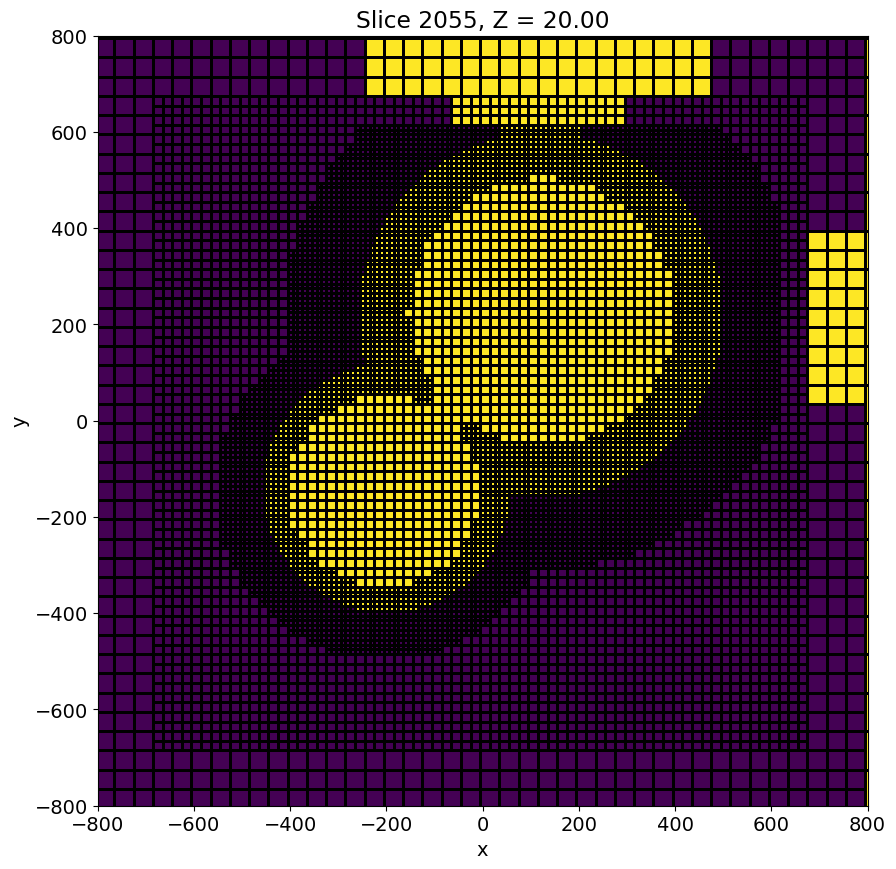

In [12]:
# Depth section from the global mesh at z=20 m 
# Mesh cells colored based on active/below topo(yellow) vs inactive/above topo(blue)
fig = Image(filename=('./GlobalMesh_z=20m.png'))
fig

In [13]:
# fig = plt.figure()
# ax = plt.subplot(111)
# fig.set_figheight(10)
# fig.set_figwidth(10)

# ySliceInd = int(np.searchsorted(mesh.cell_centers_y, 0))
# mesh.plot_slice(actCells, ax=ax, normal='Y', ind=ySliceInd, grid=True)
# # mesh.plot_slice(np.log10(mesh.vol), ax=ax, normal='Y', ind=ySliceInd, grid=True)


# ax.set_xlim(-800, 800)
# ax.set_ylim(-400, 200)
# ax.set_aspect('equal', adjustable='box')
# plt.savefig('./GlobalMesh_y=0m.png', bbox_inches='tight', orientation='landscape')

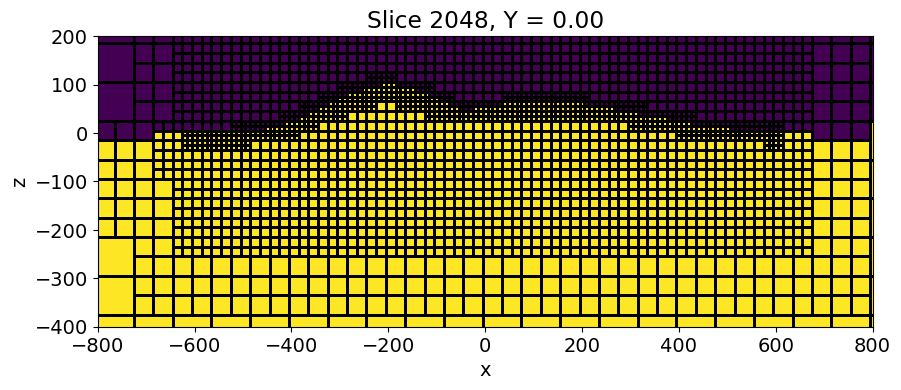

In [14]:
# E-W section from the global mesh at y=0 m 
# Mesh cells colored based on active/below topo(yellow) vs inactive/above topo(blue)
fig = Image(filename=('./GlobalMesh_y=0m.png'))
fig

## Plot local mesh sections

In [15]:
# # Plot mesh cells colored based on active cells

# local_mesh0 = local_meshes[0]

# fig = plt.figure()
# ax = plt.subplot(111)
# fig.set_figheight(10)
# fig.set_figwidth(10)

# zSliceInd = int(np.searchsorted(local_mesh0.cell_centers_z, 20))
# local_mesh0.plot_slice(local_actCells[0], ax=ax, normal='Z', ind=zSliceInd, grid=True)
# # mesh.plot_slice(np.log10(mesh.vol), ax=ax, normal='Y', ind=ySliceInd, grid=True)


# ax.set_xlim(-800, 800)
# ax.set_ylim(-800, 800)
# ax.set_aspect('equal', adjustable='box')
# plt.savefig('./LocalMesh0_z=20m.png', bbox_inches='tight', orientation='landscape')

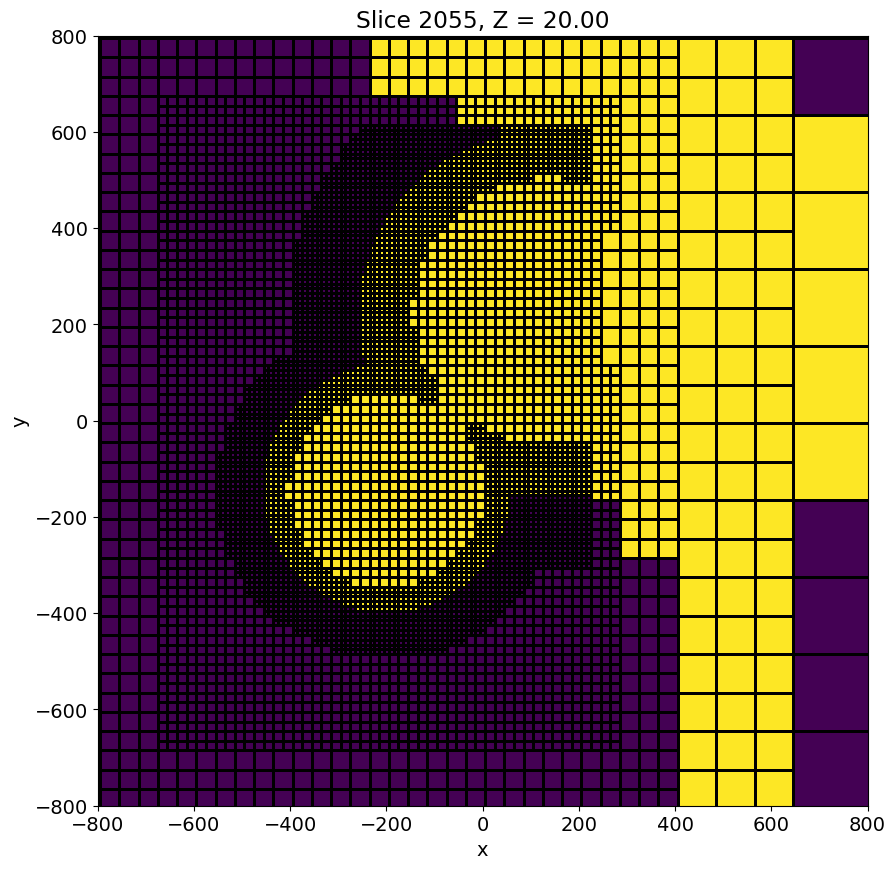

In [16]:
# Depth section from local_mesh0 at z=20 m 
# Mesh cells colored based on active/below topo(yellow) vs inactive/above topo(blue)
fig = Image(filename=('./LocalMesh0_z=20m.png'))
fig

In [17]:
# fig = plt.figure()
# ax = plt.subplot(111)
# fig.set_figheight(10)
# fig.set_figwidth(10)

# ySliceInd = int(np.searchsorted(local_mesh0.cell_centers_y, 0))
# local_mesh0.plot_slice(local_actCells[0], ax=ax, normal='Y', ind=ySliceInd, grid=True)
# # local_mesh.plot_slice(np.log10(local_mesh.cell_volumes), ax=ax, normal='Y', ind=ySliceInd, grid=True)

# # Plot observation points
# # ax.scatter(xyzRxLoc[:, 0], xyzRxLoc[:, 2], c="w")


# ax.set_xlim(-800, 800)
# ax.set_ylim(-400, 200)
# ax.set_aspect('equal', adjustable='box')
# plt.savefig('./LocalMesh0_y=0m.png', bbox_inches='tight', orientation='landscape')

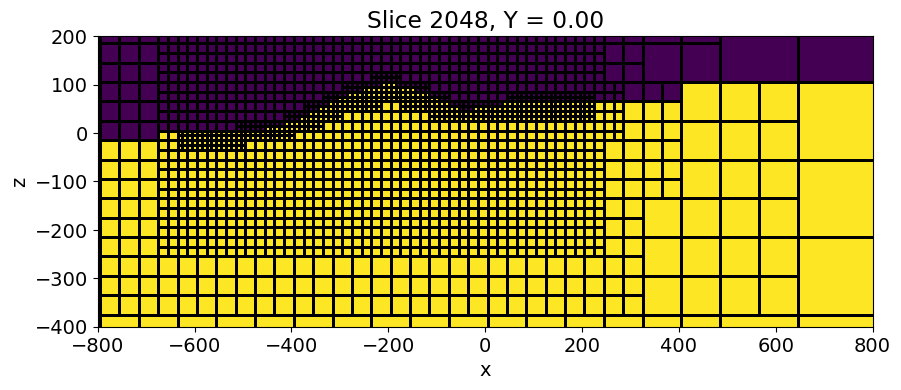

In [18]:
# E-W section from local_mesh0 at y=0 m 
# Mesh cells colored based on active/below topo(yellow) vs inactive/above topo(blue)
fig = Image(filename=('./LocalMesh0_y=0m.png'))
fig

In [19]:
# local_mesh1 = local_meshes[1]

# fig = plt.figure()
# ax = plt.subplot(111)
# fig.set_figheight(10)
# fig.set_figwidth(10)

# zSliceInd = int(np.searchsorted(local_mesh1.cell_centers_z, 20))
# local_mesh1.plot_slice(local_actCells[1], ax=ax, normal='Z', ind=zSliceInd, grid=True)
# # mesh.plot_slice(np.log10(mesh.vol), ax=ax, normal='Y', ind=ySliceInd, grid=True)


# ax.set_xlim(-800, 800)
# ax.set_ylim(-800, 800)
# ax.set_aspect('equal', adjustable='box')
# plt.savefig('./LocalMesh1_z=20m.png', box_inches='tight', orientation='landscape')

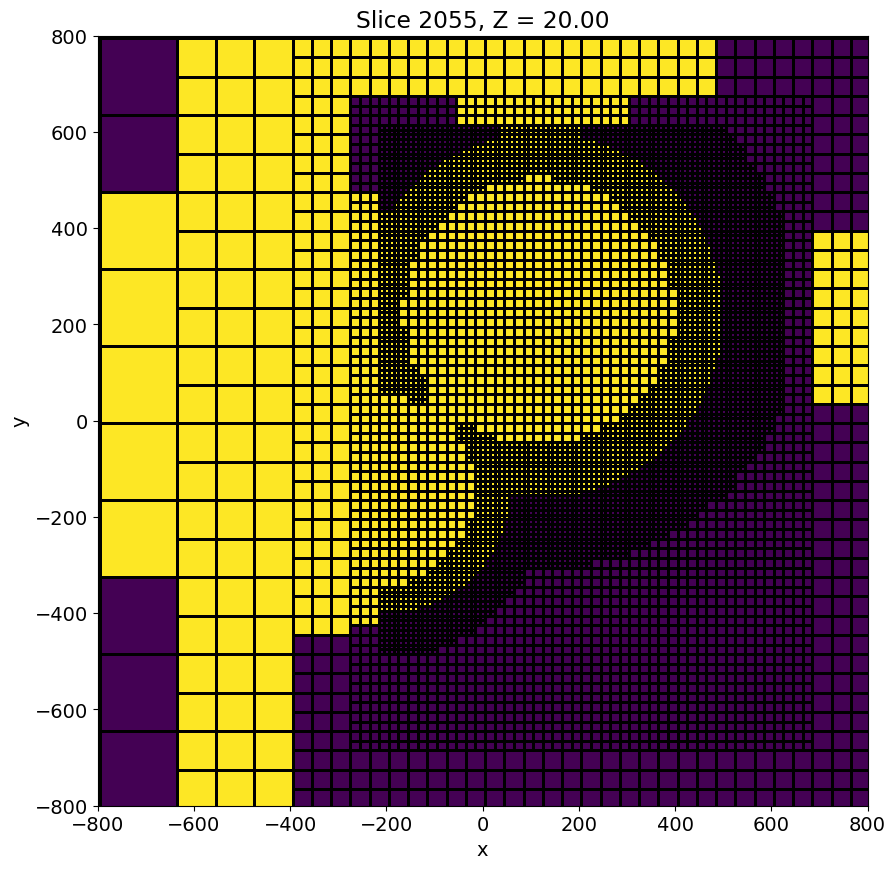

In [20]:
# Depth section from local_mesh1 at z=20 m 
# Mesh cells colored based on active/below topo(yellow) vs inactive/above topo(blue)
fig = Image(filename=('./LocalMesh1_z=20m.png'))
fig

In [21]:
# fig = plt.figure()
# ax = plt.subplot(111)
# fig.set_figheight(10)
# fig.set_figwidth(10)

# ySliceInd = int(np.searchsorted(local_mesh1.cell_centers_y, 0))
# local_mesh1.plot_slice(local_actCells[1], ax=ax, normal='Y', ind=ySliceInd, grid=True)
# # local_mesh.plot_slice(np.log10(local_mesh.cell_volumes), ax=ax, normal='Y', ind=ySliceInd, grid=True)

# # Plot observation points
# # ax.scatter(xyzRxLoc[:, 0], xyzRxLoc[:, 2], c="w")


# ax.set_xlim(-800, 800)
# ax.set_ylim(-800, 200)
# ax.set_aspect('equal', adjustable='box')
# plt.savefig('./LocalMesh1_y=0m.png', bbox_inches='tight', orientation='landscape')

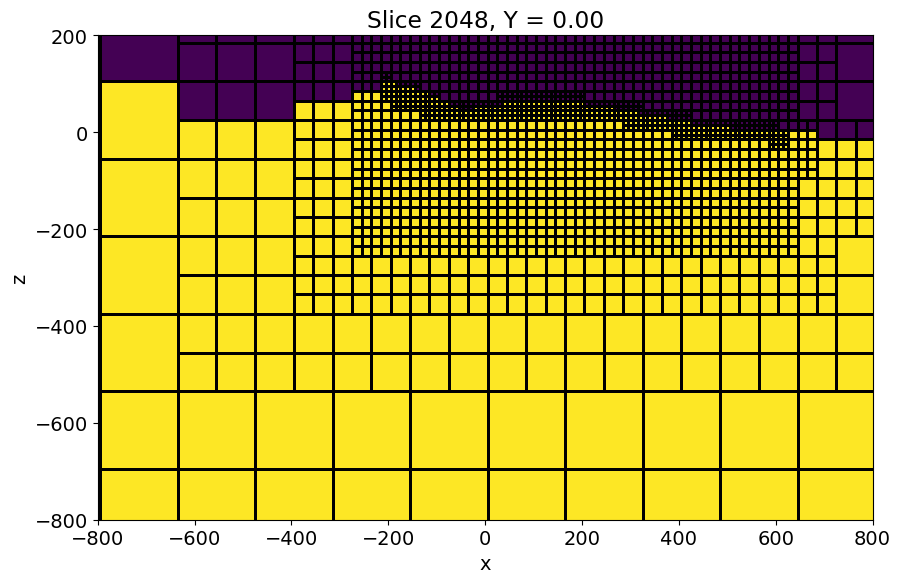

In [22]:
# E-W section from local_mesh1 at y=0 m 
# Mesh cells colored based on active/below topo(yellow) vs inactive/above topo(blue)
fig = Image(filename=('./LocalMesh1_y=0m.png'))
fig

## Create a magnetization model with two magnetized blocks

In [23]:
# Create 1D arrays for the azimuth, dip, and amplitude of magnetization for each cell. 
model_azm = np.zeros(mesh.nC)
model_dip = np.zeros(mesh.nC)
model_amp = np.ones(mesh.nC) * 1e-8

# Add Block 1 to the model
# Find cell indicies within the defined box
block1_Ind = utils.model_builder.get_indices_block(
    np.r_[0, -40, -120], 
    np.r_[210, 40, -20], 
    mesh.gridCC)[0]

# Set the azimuth, dip, and amplitude of magnetization for each cell within Block 1
model_amp[block1_Ind] = 0.08
model_azm[block1_Ind] = 155.
model_dip[block1_Ind] = 50.

# Add Block 2 to the model
# Find cell indicies within the defined box
block2_Ind = utils.model_builder.get_indices_block(
    np.r_[-320, 200, -340], 
    np.r_[-170, 400, -100], 
    mesh.gridCC)[0]

# Set the azimuth, dip, and amplitude of magnetization for each cell within Block 2
model_amp[block2_Ind] = 0.1
model_azm[block2_Ind] = 20.
model_dip[block2_Ind] = -60.


# Remove air cells from the model
model_azm = model_azm[actCells]
model_dip = model_dip[actCells]
model_amp = model_amp[actCells]

# Tranlate dip, azimuth, amplitude values to x, y, z components of the magnetization vector in each active cell
model = sdiag(model_amp) * utils.mat_utils.dip_azimuth2cartesian(model_dip, model_azm)


# Plot synthetic model sections and predicted data.

In [24]:
# Create a global survey containing all measurement locations to forward model synthetic data 
# This syntetic data is only used here for plotting and comparison.

# Define receivers, in this case point measurements of the total magnetic intensity (TMI)
receivers = magnetics.receivers.Point(xyzRxLoc)
# Define the source field using the azimuth, dip, and amplitude of the inducing field
srcField = magnetics.sources.UniformBackgroundField(receiver_list=[receivers], amplitude=B0_amp, 
                                                    inclination=B0_inc, declination=B0_dec)
# Create the global survey object
survey = magnetics.survey.Survey(srcField)
print('nData:', survey.nD)


# Create identity map. Only an identity map is used for the chiMap in this mag inversion. 
# For DC resisvity inversions an exponential map is often used here since 
# resistities can vary over many orders of magnitude. 
idenMap = maps.IdentityMap(nP=nActCells * 3)

# Create the global simulation
simulation = magnetics.simulation.Simulation3DIntegral(survey=survey, mesh=mesh, chiMap=idenMap, 
                                                       ind_active=actCells, model_type="vector")

# Forward model synthetic data from the 2 block model that we created
d = simulation.dpred(mkvc(model))

# Add normally distributed noise with a standard deviation of 5 nT 
std = 5  # nT
synthetic_data = d + np.random.randn(len(d)) * std

# 
wd = np.ones(len(d)) * std


nData: 625


In [45]:
# ###########################################################################
# # A simple function to plot vectors in TreeMesh
# #
# # Should eventually end up on discretize
# #


# def plotVectorSectionsOctree(
#     mesh,
#     m,
#     normal="X",
#     ind=0,
#     vmin=None,
#     vmax=None,
#     scale=1.0,
#     vec="k",
#     axs=None,
#     actCellMap=None,
#     fill=True,
#     grid=False
# ):

#     """
#     Plot section through a 3D tensor model
#     """
#     # plot recovered model
#     normalInd = {"X": 0, "Y": 1, "Z": 2}[normal]
#     antiNormalInd = {"X": [1, 2], "Y": [0, 2], "Z": [0, 1]}[normal]

#     h2d = (mesh.h[antiNormalInd[0]], mesh.h[antiNormalInd[1]])
#     x2d = (mesh.x0[antiNormalInd[0]], mesh.x0[antiNormalInd[1]])

#     #: Size of the sliced dimension
#     szSliceDim = len(mesh.h[normalInd])
#     if ind is None:
#         ind = int(szSliceDim // 2)

#     cc_tensor = [None, None, None]
#     for i in range(3):
#         cc_tensor[i] = np.cumsum(np.r_[mesh.x0[i], mesh.h[i]])
#         cc_tensor[i] = (cc_tensor[i][1:] + cc_tensor[i][:-1]) * 0.5
#     slice_loc = cc_tensor[normalInd][ind]

#     # Create a temporary TreeMesh with the slice through
#     temp_mesh = TreeMesh(h2d, x2d)
#     level_diff = mesh.max_level - temp_mesh.max_level

#     XS = [None, None, None]
#     XS[antiNormalInd[0]], XS[antiNormalInd[1]] = np.meshgrid(
#         cc_tensor[antiNormalInd[0]], cc_tensor[antiNormalInd[1]]
#     )
#     XS[normalInd] = np.ones_like(XS[antiNormalInd[0]]) * slice_loc
#     loc_grid = np.c_[XS[0].reshape(-1), XS[1].reshape(-1), XS[2].reshape(-1)]
#     inds = np.unique(mesh._get_containing_cell_indexes(loc_grid))

#     grid2d = mesh.gridCC[inds][:, antiNormalInd]
#     levels = mesh._cell_levels_by_indexes(inds) - level_diff
#     temp_mesh.insert_cells(grid2d, levels)
#     tm_gridboost = np.empty((temp_mesh.nC, 3))
#     tm_gridboost[:, antiNormalInd] = temp_mesh.gridCC
#     tm_gridboost[:, normalInd] = slice_loc

#     # Interpolate values to mesh.gridCC if not 'CC'
#     mx = actCellMap * m[:, 0]
#     my = actCellMap * m[:, 1]
#     mz = actCellMap * m[:, 2]

#     m = np.c_[mx, my, mz]

#     # Interpolate values from mesh.gridCC to grid2d
#     ind_3d_to_2d = mesh._get_containing_cell_indexes(tm_gridboost)
#     v2d = m[ind_3d_to_2d, :]
#     amp = np.sum(v2d ** 2.0, axis=1) ** 0.5
# #     v2d = sdiag(1./amp) * v2d

#     if vmin is None:
#         vmin = np.nanmin(amp)
    
#     if vmax is None:
#         vmax = np.nanmax(amp)

#     if axs is None:
#         axs = plt.subplot(111)

#     if fill:
#         dat = temp_mesh.plot_image(amp, ax=axs, clim=[vmin, vmax], grid=grid)

#     axs.quiver(
#         temp_mesh.gridCC[:, 0],
#         temp_mesh.gridCC[:, 1],
#         v2d[:, antiNormalInd[0]],
#         v2d[:, antiNormalInd[1]],
#         pivot="mid",
#         scale_units="inches",
#         scale=scale,
# #         linewidths=(1,),
#         edgecolors=(vec),
# #         headaxislength=0.1,
# #         headwidth=10,
# #         headlength=30,
#     )
#     return dat


In [26]:
# xSliceInd = int(np.searchsorted(mesh.cell_centers_x, -200))
# ySliceInd = int(np.searchsorted(mesh.cell_centers_y, 0))
# zSliceInd = int(np.searchsorted(mesh.cell_centers_z, -110))

# # Plot the model and data
# plt.figure(figsize=(20, 20))
# # Plot the vector model
# ax = plt.subplot(2, 2, 1)
# plotVectorSectionsOctree(
#     mesh,
#     model,
#     axs=ax,
#     normal="Z",
#     ind=zSliceInd,
#     actCellMap=actCellsMap,
#     scale=0.4,
#     vmin=None,
#     vmax=None,
#     grid=False
# )
# ax.set_xlim([-600, 600])
# ax.set_ylim([-600, 600])
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_title("Depth section at z=-110 m")
# plt.gca().set_aspect("equal", adjustable="box")

# # Plot the vector model
# ax = plt.subplot(2, 2, 2)
# plotVectorSectionsOctree(
#     mesh,
#     model,
#     axs=ax,
#     normal="Y",
#     ind=ySliceInd,
#     actCellMap=actCellsMap,
#     scale=0.4,
#     vmin=None,
#     vmax=None,
#     grid=False
# )
# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# ax.set_xlabel("x")
# ax.set_ylabel("z")
# ax.set_title("E-W section at y=0 m")
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(2, 2, 3)
# im = utils.plot_utils.plot2Ddata(xyzRxLoc, synthetic_data, ax=ax)
# plt.colorbar(im[0])
# ax.set_title("Predicted data")
# ax.set_xlim([-600, 600])
# ax.set_ylim([-600, 600])
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# plt.gca().set_aspect("equal", adjustable="box")

# # Plot the vector model
# ax = plt.subplot(2, 2, 4)
# plotVectorSectionsOctree(
#     mesh,
#     model,
#     axs=ax,
#     normal="X",
#     ind=xSliceInd,
#     actCellMap=actCellsMap,
#     scale=0.4,
#     vmin=None,
#     vmax=None,
#     grid=False
# )
# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# ax.set_xlabel("y")
# ax.set_ylabel("z")
# ax.set_title("N-S section at x=-200 m")
# plt.gca().set_aspect("equal", adjustable="box")

# plt.show()


# plt.savefig('./Multipanel_model_data_overview.png', bbox_inches='tight', orientation='landscape')

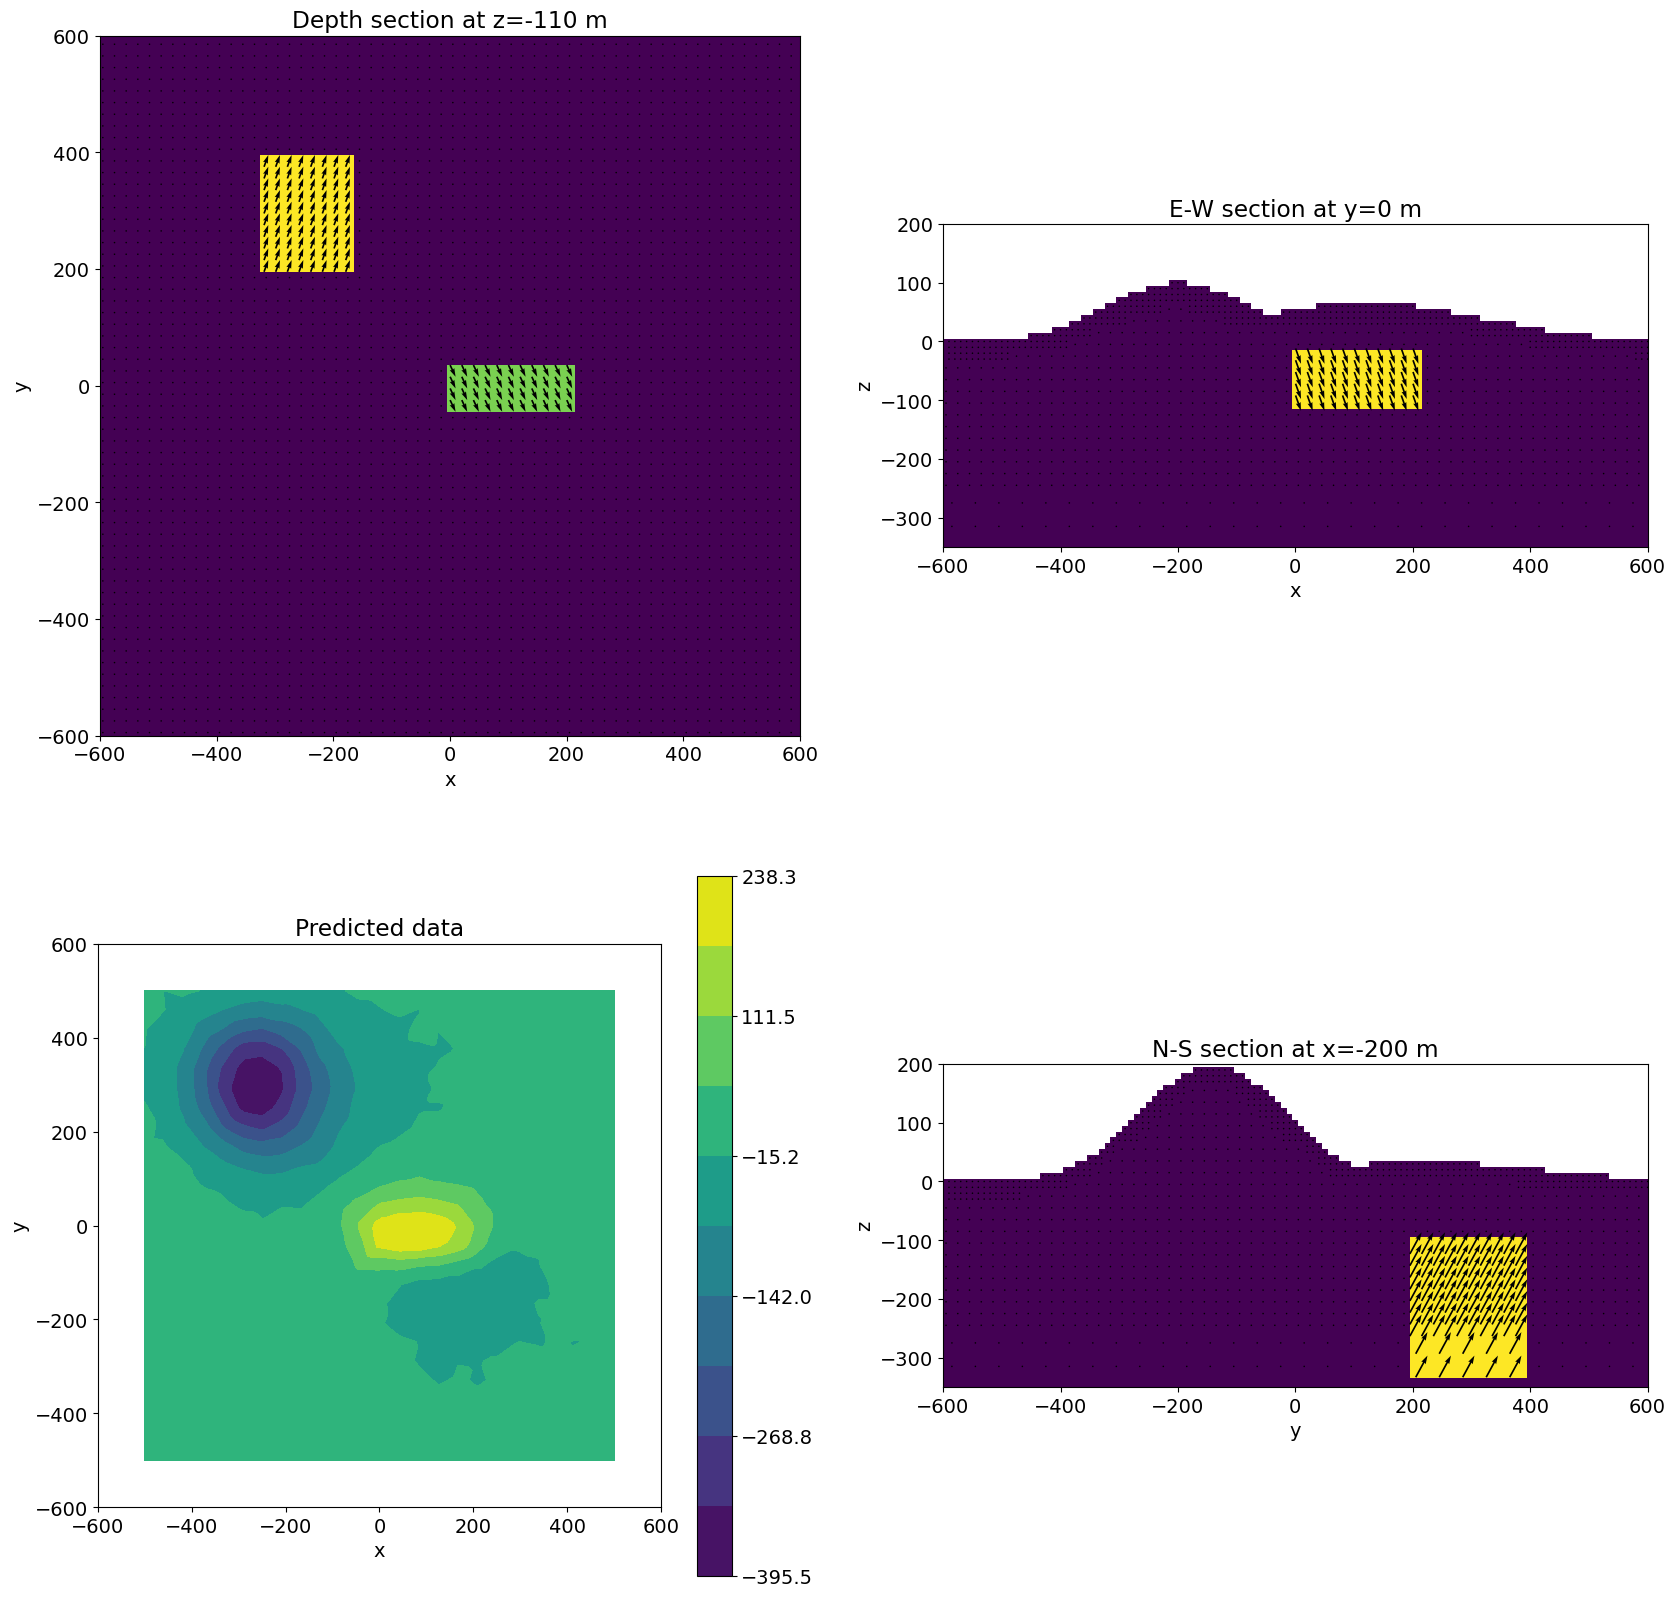

In [27]:
# x, y, and z sections through the synthetic 2 block model and the predicted data from this model.
fig = Image(filename=('./Multipanel_model_data_overview.png'))
fig

## Create the maps for each tile and combine the tiles in a meta-simulation

In [28]:
# Setup tiled meta-simulation

simulations = []
tile_mappings = []
local_actCells = []
local_actCellMap = []
local_nActCells = []
for ii, local_survey in enumerate(local_surveys):
    # Create tile_maps to map from each local mesh to the global mesh
    tile_map = maps.TileMap(mesh, actCells, local_meshes[ii], components=3)
    
    local_actives = tile_map.local_active
    print(local_actives)
    print(local_actives.shape)
    n_local_actives = int(np.sum(local_actives))
    local_activesMap = maps.InjectActiveCells(local_meshes[ii], local_actives , np.nan)
    
    # Create a reduced identity map for each tile 
    local_idenMap = maps.IdentityMap(nP=n_local_actives*3)

    # Create the local simulation for each tile
    local_simulation = magnetics.simulation.Simulation3DIntegral(survey=local_survey, mesh=local_meshes[ii], chiMap=local_idenMap, 
                                                           ind_active=local_actives, model_type="vector")

    tile_mappings.append(tile_map)
    simulations.append(local_simulation)
    local_actCells.append(local_actives)
    local_nActCells.append(n_local_actives)
    local_actCellMap.append(local_activesMap)
    
    print("tile_map size:", tile_map.shape)
    print("global mesh size:", mesh.nC)
    print("global mesh nActCells:", nActCells)
    print("global mesh nActCells*3:", 3*nActCells)
    print("local mesh size:", local_meshes[ii].nC)
    print("local mesh nActCells:", local_nActCells[ii])
    print("local mesh nActCells*3:", 3*local_nActCells[ii])
    print("\n")

# Combine local simulations into a meta-simulation
time0 = time.time()
MultiProcessingMetaSim = MultiprocessingMetaSimulation(simulations, tile_mappings)
time1 = time.time()
print(' MultiprocessingMetaSimulation setup time:' + str(time1-time0))


[ True  True  True ... False False False]
(145482,)
tile_map size: (260916, 366846)
global mesh size: 201776
global mesh nActCells: 122282
global mesh nActCells*3: 366846
local mesh size: 145482
local mesh nActCells: 86972
local mesh nActCells*3: 260916


[ True  True  True ... False False False]
(143963,)
tile_map size: (258546, 366846)
global mesh size: 201776
global mesh nActCells: 122282
global mesh nActCells*3: 366846
local mesh size: 143963
local mesh nActCells: 86182
local mesh nActCells*3: 258546




C:\/Users//mamitchell//git//simpeg_micmitch\SimPEG\meta\multiprocessing.py:227: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  super().__init__(simulations, mappings)
C:\/Users//mamitchell//git//simpeg_micmitch\SimPEG\meta\multiprocessing.py:246: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  sim_chunk = MetaSimulation(


 MultiprocessingMetaSimulation setup time:13.22060513496399


## Create a data object for the meta-simulation 

In [29]:
# Forward model synthetic data from the 2 Block model, add Gaussian noise with a floor of 5 nT, and assign data to the 
# meta-simulation data object
data_metaSim = MultiProcessingMetaSim.make_synthetic_data(utils.mkvc(model), relative_error=0.00, noise_floor=5, f=None, add_noise=True)

# Check noise/uncertainties
noiseCheck = np.abs(data_metaSim.dclean - data_metaSim.dobs)
print('max(noiseCheck)', np.max(noiseCheck))
print('mean(noiseCheck)', np.mean(noiseCheck))
print('median(noiseCheck)', np.median(noiseCheck))

# Compare synthetic data from the meta-simulation and the global simulation
diff = np.abs(data_metaSim.dobs - d)
print('max(|diff|)', np.max(diff))
print('mean(|diff|)', np.mean(diff))
print('median(|diff|)', np.median(diff))


max(noiseCheck) 16.071818307272025
mean(noiseCheck) 3.909253097663104
median(noiseCheck) 3.2762166509652957
max(|diff|) 27.611965902674342
mean(|diff|) 5.095112954000186
median(|diff|) 3.8905045153115063


## Create the meta-simulation data mistfit object

In [30]:
# Create the L2 data mistfit object
dMisfit = data_misfit.L2DataMisfit(data=data_metaSim, simulation=MultiProcessingMetaSim)

## Specify inversion parameters

In [31]:
# Initialize the starting model (m0) and reference model (mRef)
m0 = np.ones(3 * nActCells) * 1e-8  
mRef = np.zeros(3 * nActCells)

# Set up the vector amplitude regularization
reg_amp = regularization.VectorAmplitude(
    mesh, mapping=idenMap, active_cells=actCells,
    reference_model_in_smooth=True,
)
# Use L1 norms in the smallness and directional derivative terms of the model objective function
reg_amp.norms = [1.0, 1.0, 1.0, 1.0]
# reg_amp.alpha_s = 0.0
reg_amp.gradient_type = "total"
reg_amp.reference_model = mRef


# Define model bounds
lower_bound = np.kron(np.asarray([-np.inf, -np.inf, -np.inf]), np.ones(nActCells))
upper_bound = np.kron(np.asarray([np.inf, np.inf, np.inf]), np.ones(nActCells))

# Specify how the optimization will proceed, set magnetization bounds
opt = optimization.ProjectedGNCG(maxIter=35, lower=lower_bound, upper=upper_bound, maxIterLS=70, maxIterCG=20, tolCG=1e-4)

# Formulate the inversion problem  by combining the data misfit, regularization, and optimization method
invProb = inverse_problem.BaseInvProblem(dMisfit, reg_amp, opt)

# Specify a list of directives which control the inverson
# Estimate a starting value of the trade-off parameter beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=100)
# Define the beta cooling schedule
beta_schedule = directives.BetaSchedule(coolingFactor=5., coolingRate=3.)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights()

# Iteratively Reweighted Least Squares parameters for the sparse norm solution
IRLS = directives.Update_IRLS(f_min_change=1e-4, minGNiter=1, max_irls_iterations=25, beta_tol=5e-1)

# Add a Jacobi pre-conditioner
update_Jacobi = directives.UpdatePreconditioner()

# Create the inversion object which combines the inverse problem and its associated directives
inv = inversion.BaseInversion(
    invProb, directiveList=[
        sensitivity_weights,
        beta_est,
        beta_schedule,
        IRLS,
        update_Jacobi
    ]
)


## Run the inversion

In [32]:
print('Starting inversion')
time0 = time.time()
mInv_MVI_amp = inv.run(m0)
time1 = time.time()
print('Inv time:' + str(time1-time0))

# Save the recovered inversion model
np.save('mInv_MVI_amp_L1111_Tiled_2BlockExample.npy', mInv_MVI_amp)


Starting inversion

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.81e+06  7.62e+04  4.81e-10  7.62e+04    1.27e+06      0              
   1  1.91e+06  7.29e+04  4.09e-04  7.37e+04    5.45e+05      0              
   2  9.54e+05  7.04e+04  1.38e-03  7.17e+04    4.83e+05      0   Skip BFGS  
   3  9.54e+04  6.65e+04  4.33e-03  6.69e+04    7.30e+05      0   Skip BFGS  
   4  4.77e+04  3.81e+04  1.36e-01  4.45e+04    1.93e+05      0              
   5  2.38e+04  2.57e+04  3.15e-01  3.32e+04    1.47e+05      0   Skip BFGS  
   6  2.38e+03  1.46e+04  6.31e-01  1.61e+0

## Forward model predicted data from the recovered model

In [33]:
time0 = time.time()
dPred = MultiProcessingMetaSim.dpred(mInv_MVI_amp)
time1 = time.time()
print('FwdMod time:' + str(time1-time0))
np.save('dPred_mInv_MVI_amp_L1111_Tiled_2BlockExample.npy', dPred)


FwdMod time:0.05272173881530762


## Plot sections comparing the recovered inversion model to the synthetic 2 block model

In [57]:
# matplotlib.rcParams['font.size'] = 20
# z_sliceInd = int(np.searchsorted(mesh.cell_centers_z, -110))

# plt.figure(figsize=(30,26))
# ax = plt.subplot(2, 1, 1)
# dat1 = plotVectorSectionsOctree(
#         mesh,
#         model,
#         axs=ax,
#         normal="Z",
#         ind=z_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.2,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-600, 600])
# ax.set_title("True Model (z = -110 m)")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# plt.colorbar(dat1[0], ax=ax, shrink=1.0)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(2, 1, 2)
# dat2 = plotVectorSectionsOctree(
#         mesh,
#         mInv_MVI_amp.reshape((nActCells, 3), order="F"),
#         axs=ax,
#         normal="Z",
#         ind=z_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.2,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-600, 600])
# ax.set_title("MVI_amp_L1111 (z = -110 m)")
# ax.set_xlabel("x")
# ax.set_ylabel("z")
# plt.colorbar(dat2[0], ax=ax, shrink=1.0)
# plt.gca().set_aspect("equal", adjustable="box")

# plt.savefig('./mInv_MVI_amp_L1111_zSection110m_TrueComp.png', bbox_inches='tight', orientation='portrait')

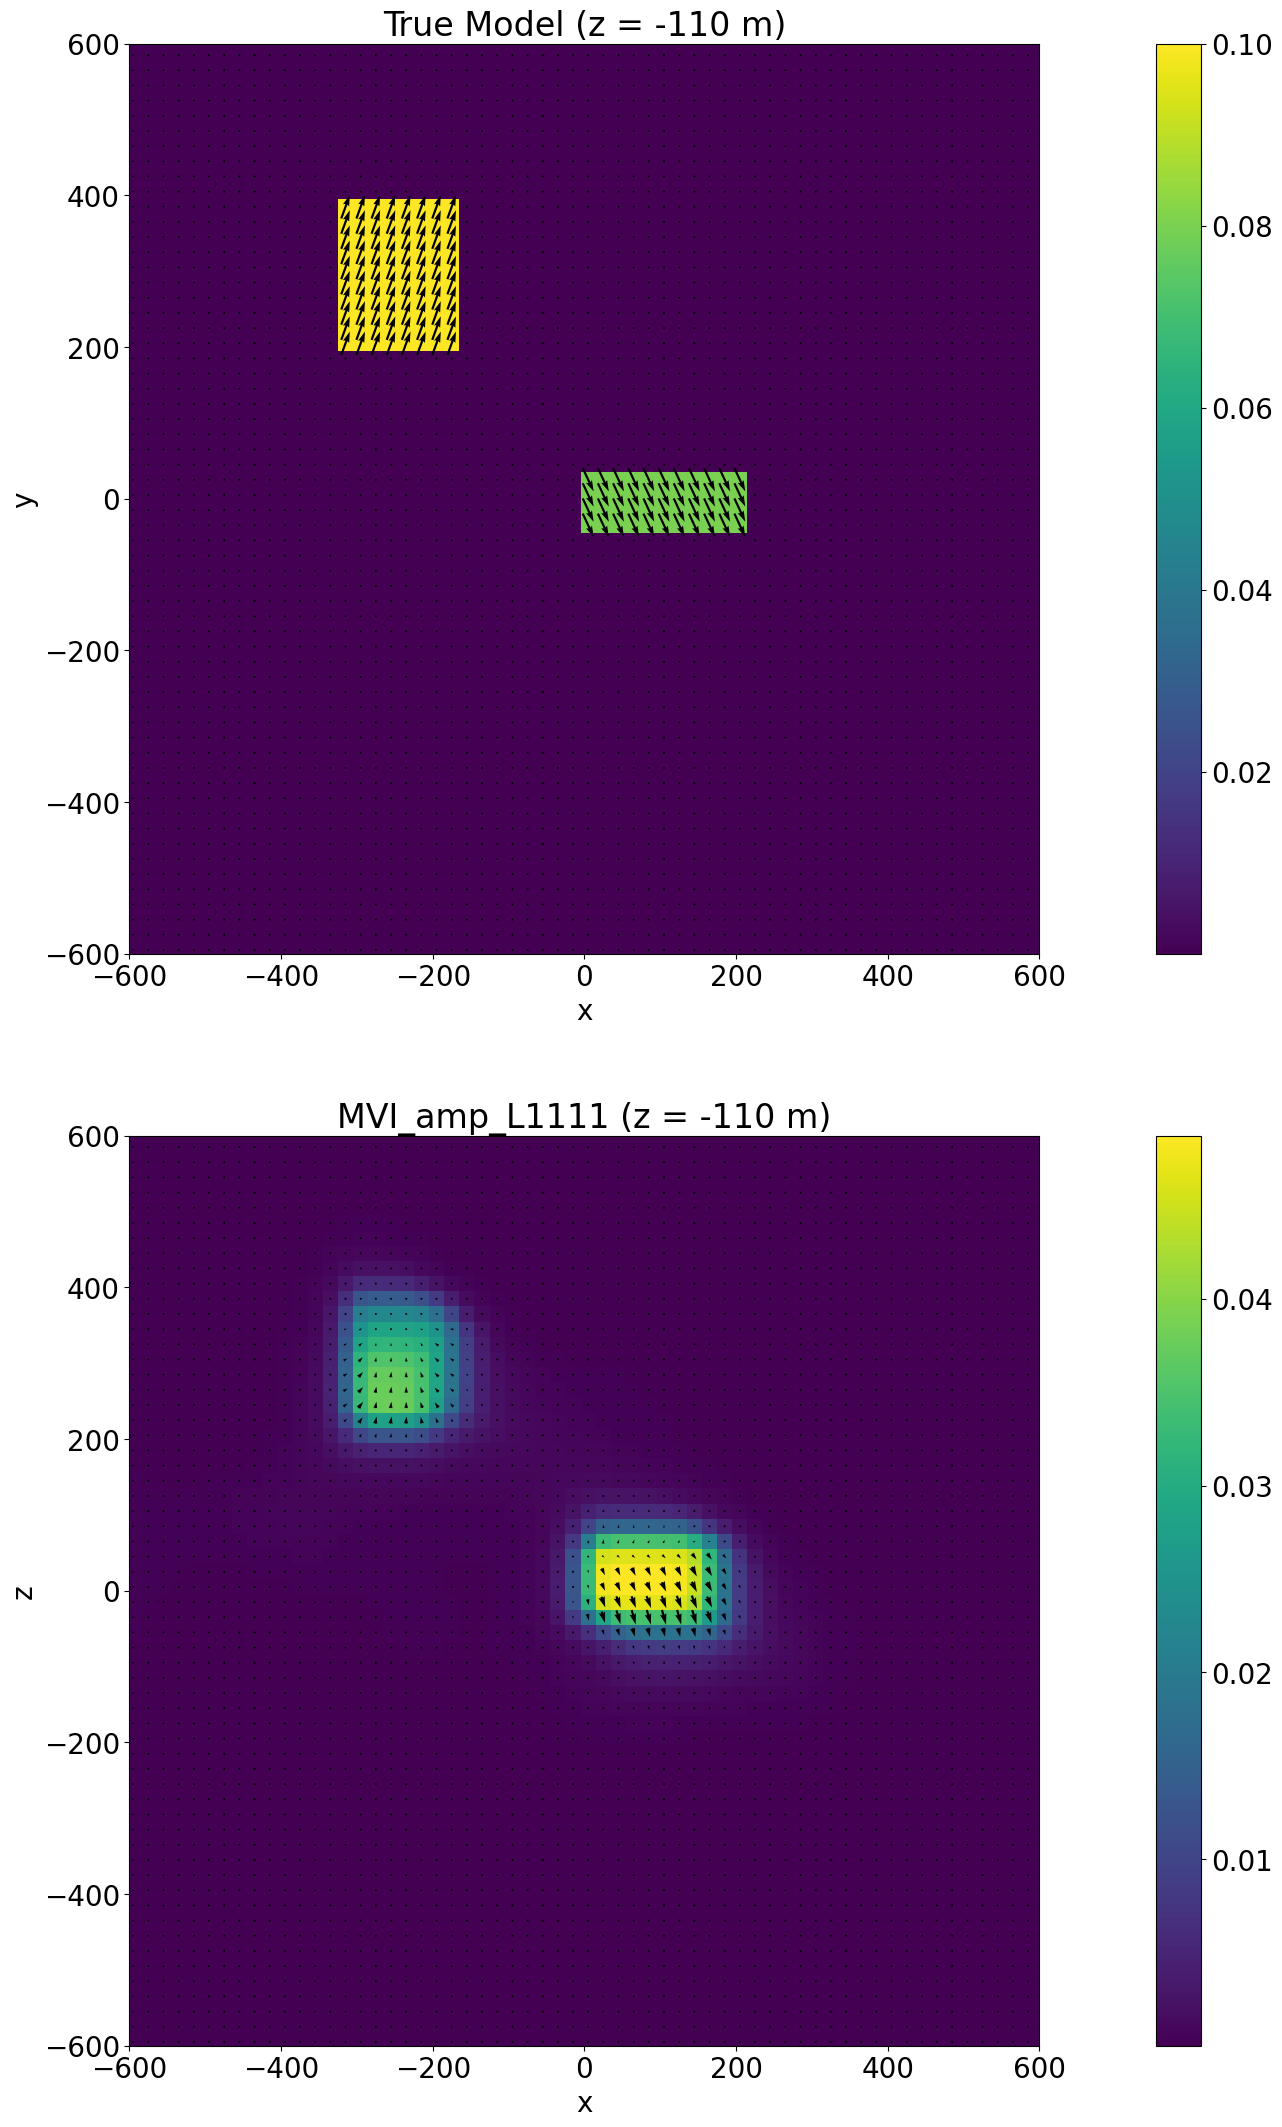

In [58]:
# Depth sections from the synthetic model and the recovered inversion model at z=-110 m 
fig = Image(filename=('./mInv_MVI_amp_L1111_zSection110m_TrueComp.png'))
fig

In [59]:
# matplotlib.rcParams['font.size'] = 20
# y1_sliceInd = int(np.searchsorted(mesh.cell_centers_y, 0))
# y2_sliceInd = int(np.searchsorted(mesh.cell_centers_y, 300))

# plt.figure(figsize=(30,40))

# ax = plt.subplot(4, 1, 1)
# dat1 = plotVectorSectionsOctree(
#         mesh,
#         model,
#         axs=ax,
#         normal="Y",
#         ind=y1_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# # ax.set_title("True Model")
# ax.set_xlabel("x")
# ax.set_ylabel("z")
# ax.set_title('True Model (E-W section at y = 0 m)')
# plt.colorbar(dat1[0], ax=ax, shrink=0.9)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(4, 1, 2)
# dat2 = plotVectorSectionsOctree(
#         mesh,
#         mInv_MVI_amp.reshape((nActCells, 3), order="F"),
#         axs=ax,
#         normal="Y",
#         ind=y1_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# # ax.set_title("MVI_amp_L1000")
# ax.set_xlabel("x")
# ax.set_ylabel("z")
# ax.set_title('MVI_amp_L1111 (E-W section at y = 0 m)')
# plt.colorbar(dat2[0], ax=ax, shrink=0.9)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(4, 1, 3)
# dat1 = plotVectorSectionsOctree(
#         mesh,
#         model,
#         axs=ax,
#         normal="Y",
#         ind=y2_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# # ax.set_title("True Model")
# ax.set_xlabel("x")
# ax.set_ylabel("z")
# ax.set_title('True Model (E-W section at y = 300 m)')
# plt.colorbar(dat1[0], ax=ax, shrink=0.9)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(4, 1, 4)
# dat2 = plotVectorSectionsOctree(
#         mesh,
#         mInv_MVI_amp.reshape((nActCells, 3), order="F"),
#         axs=ax,
#         normal="Y",
#         ind=y2_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# # ax.set_title("MVI_amp_L1000")
# ax.set_xlabel("x")
# ax.set_ylabel("z")
# ax.set_title('MVI_amp_L1111 (E-W section at y = 300 m)')
# plt.colorbar(dat2[0], ax=ax, shrink=0.9)
# plt.gca().set_aspect("equal", adjustable="box")

# plt.savefig('./mInv_MVI_amp_L1111_ySection_TrueComp.png', bbox_inches='tight', orientation='portrait')

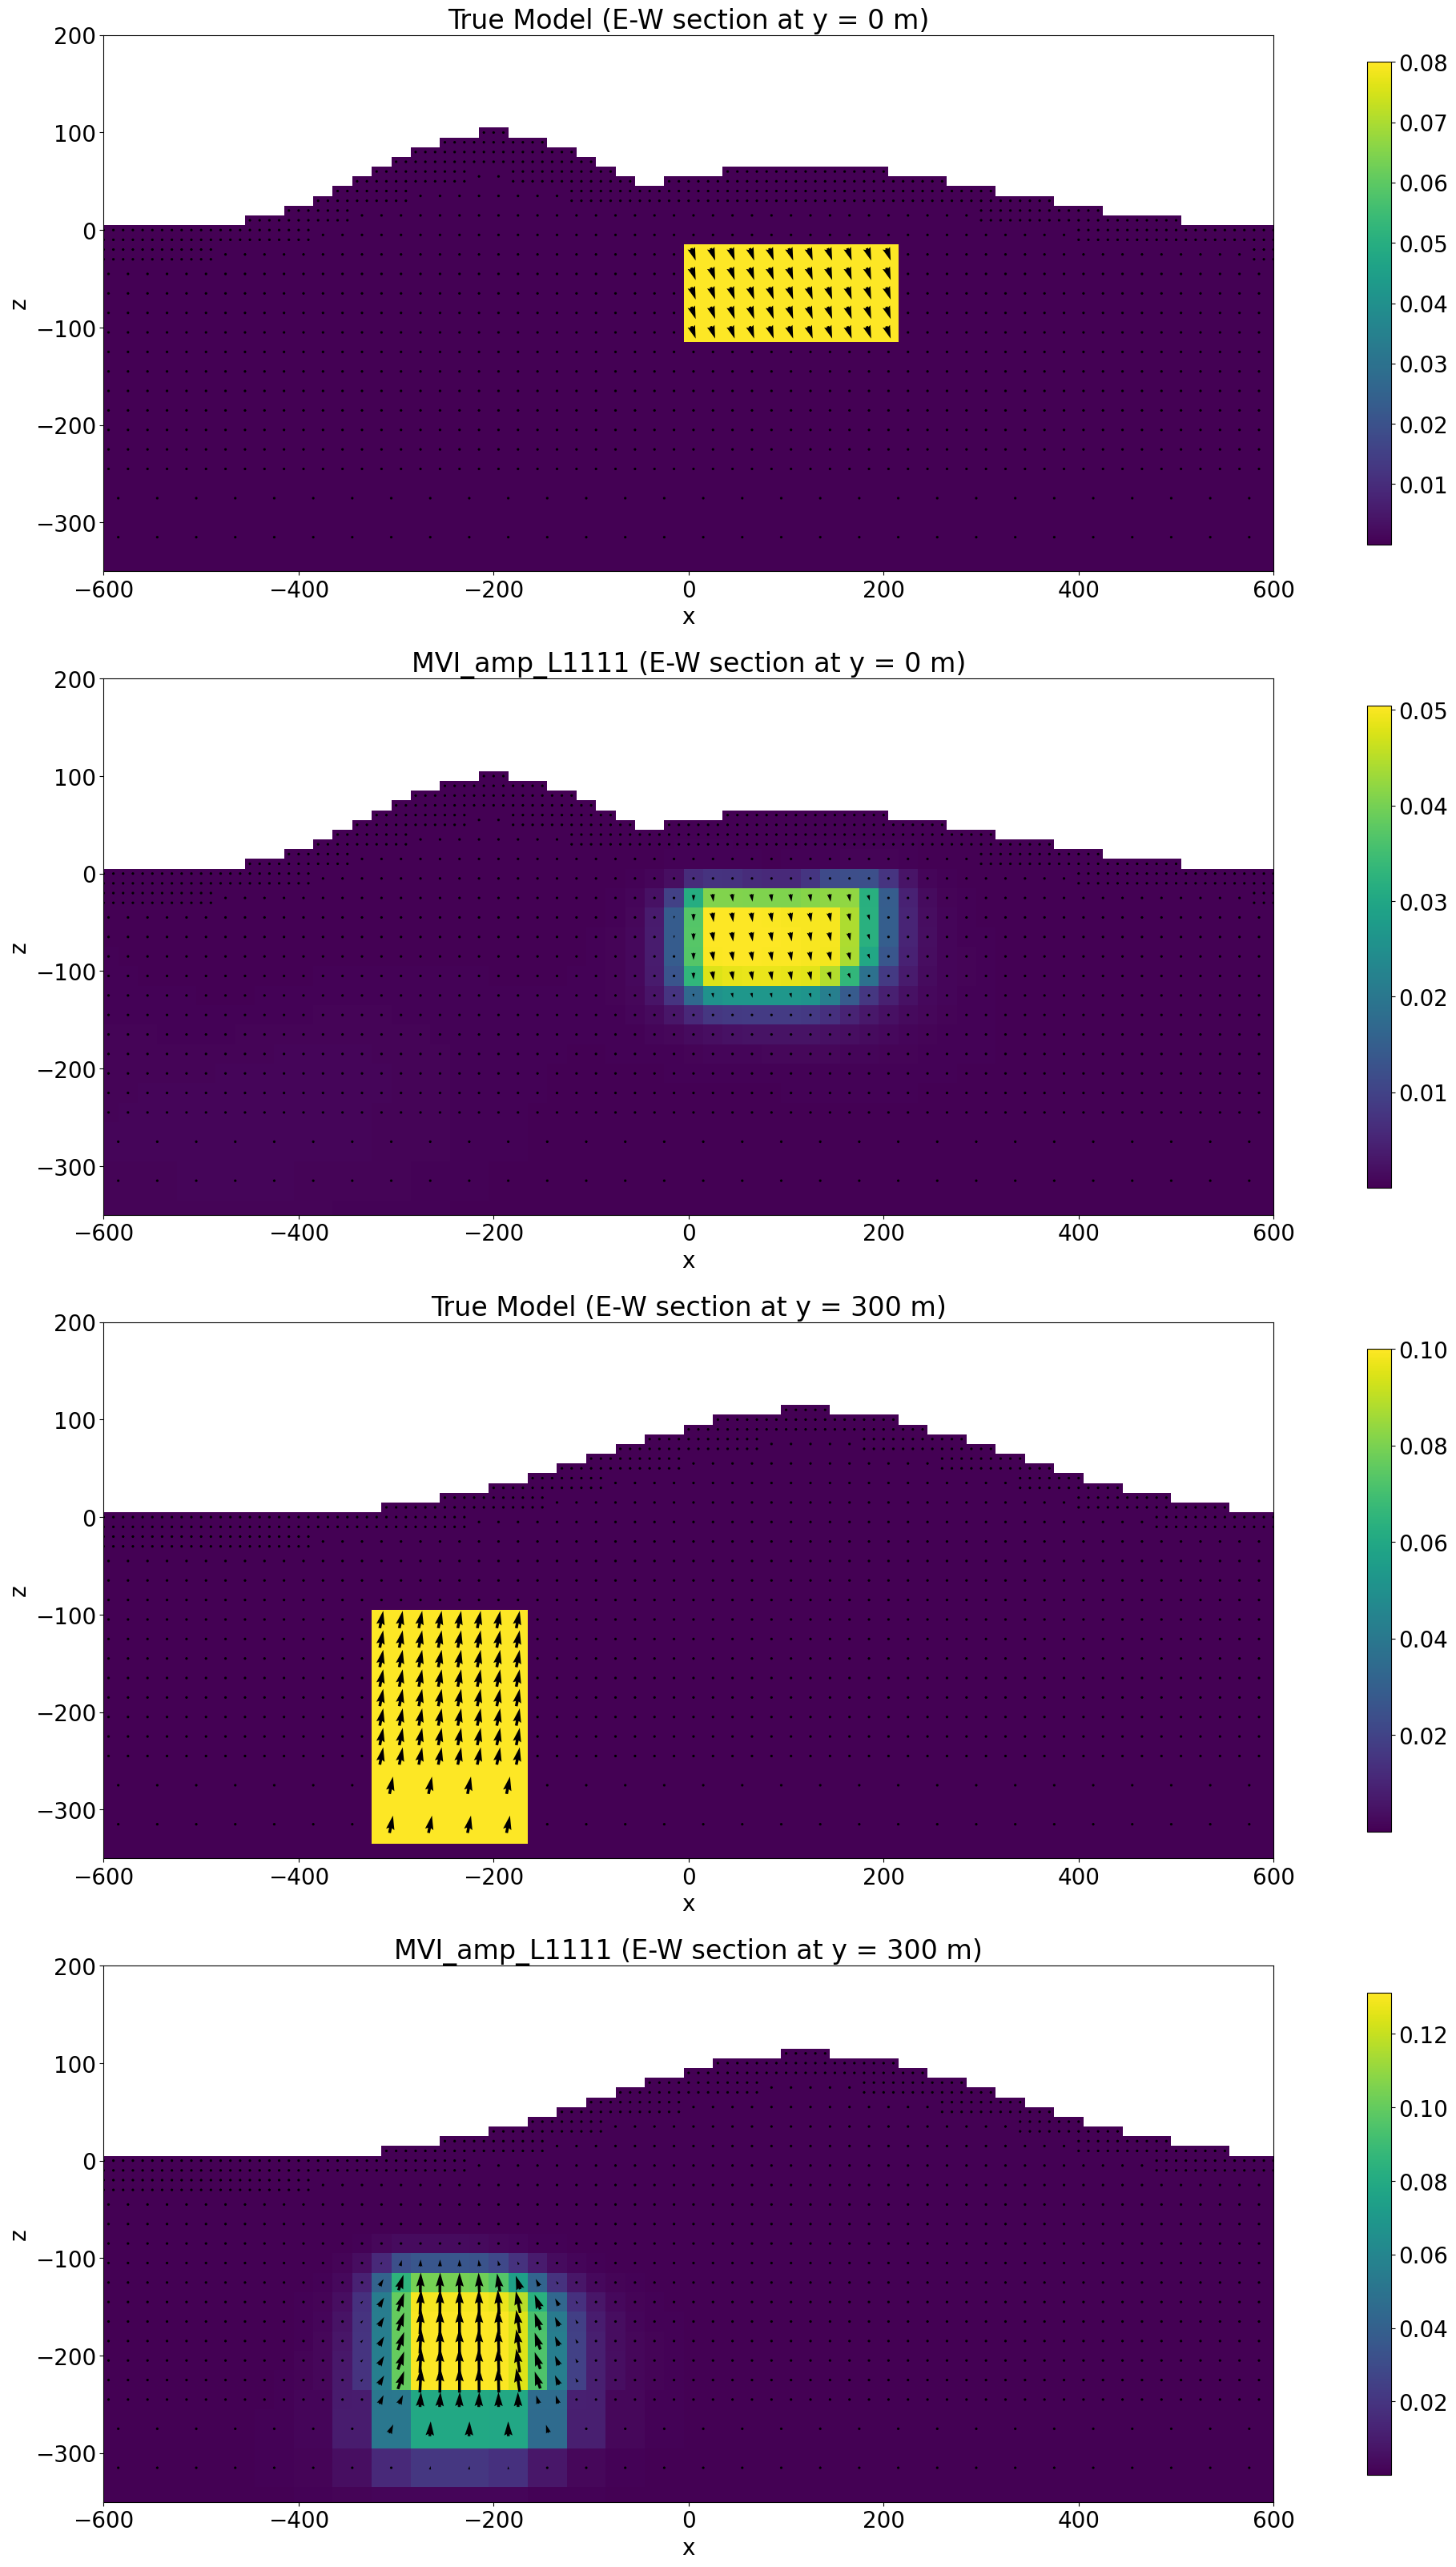

In [60]:
# E-W sections from the synthetic model and the recovered inversion model at y=0 m and y=300 m
fig = Image(filename=('./mInv_MVI_amp_L1111_ySection_TrueComp.png'))
fig

In [61]:
# matplotlib.rcParams['font.size'] = 20
# x1_sliceInd = int(np.searchsorted(mesh.cell_centers_x, -300))
# x2_sliceInd = int(np.searchsorted(mesh.cell_centers_x, 100))

# plt.figure(figsize=(30,40))

# ax = plt.subplot(4, 1, 1)
# dat1 = plotVectorSectionsOctree(
#         mesh,
#         model,
#         axs=ax,
#         normal="X",
#         ind=x1_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# # ax.set_title("True Model")
# ax.set_xlabel("y")
# ax.set_ylabel("z")
# ax.set_title('True Model (N-S section at x = -300 m)')
# plt.colorbar(dat1[0], ax=ax, shrink=0.9)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(4, 1, 2)
# dat2 = plotVectorSectionsOctree(
#         mesh,
#         mInv_MVI_amp.reshape((nActCells, 3), order="F"),
#         axs=ax,
#         normal="X",
#         ind=x1_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# # ax.set_title("MVI_amp_L1000")
# ax.set_xlabel("y")
# ax.set_ylabel("z")
# ax.set_title('MVI_amp_L1111 (N-S section at x = -300 m)')
# plt.colorbar(dat2[0], ax=ax, shrink=0.9)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(4, 1, 3)
# dat1 = plotVectorSectionsOctree(
#         mesh,
#         model,
#         axs=ax,
#         normal="X",
#         ind=x2_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# # ax.set_title("True Model")
# ax.set_xlabel("y")
# ax.set_ylabel("z")
# ax.set_title('True Model (N-S section at x = 100 m)')
# plt.colorbar(dat1[0], ax=ax, shrink=0.9)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(4, 1, 4)
# dat2 = plotVectorSectionsOctree(
#         mesh,
#         mInv_MVI_amp.reshape((nActCells, 3), order="F"),
#         axs=ax,
#         normal="X",
#         ind=x2_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# # ax.set_title("MVI_amp_L1000")
# ax.set_xlabel("y")
# ax.set_ylabel("z")
# ax.set_title('MVI_amp_L1111 (N-S section at x = 100 m)')
# plt.colorbar(dat2[0], ax=ax, shrink=0.9)
# plt.gca().set_aspect("equal", adjustable="box")

# plt.savefig('./mInv_MVI_amp_L1111_xSection_TrueComp.png', bbox_inches='tight', orientation='portrait')

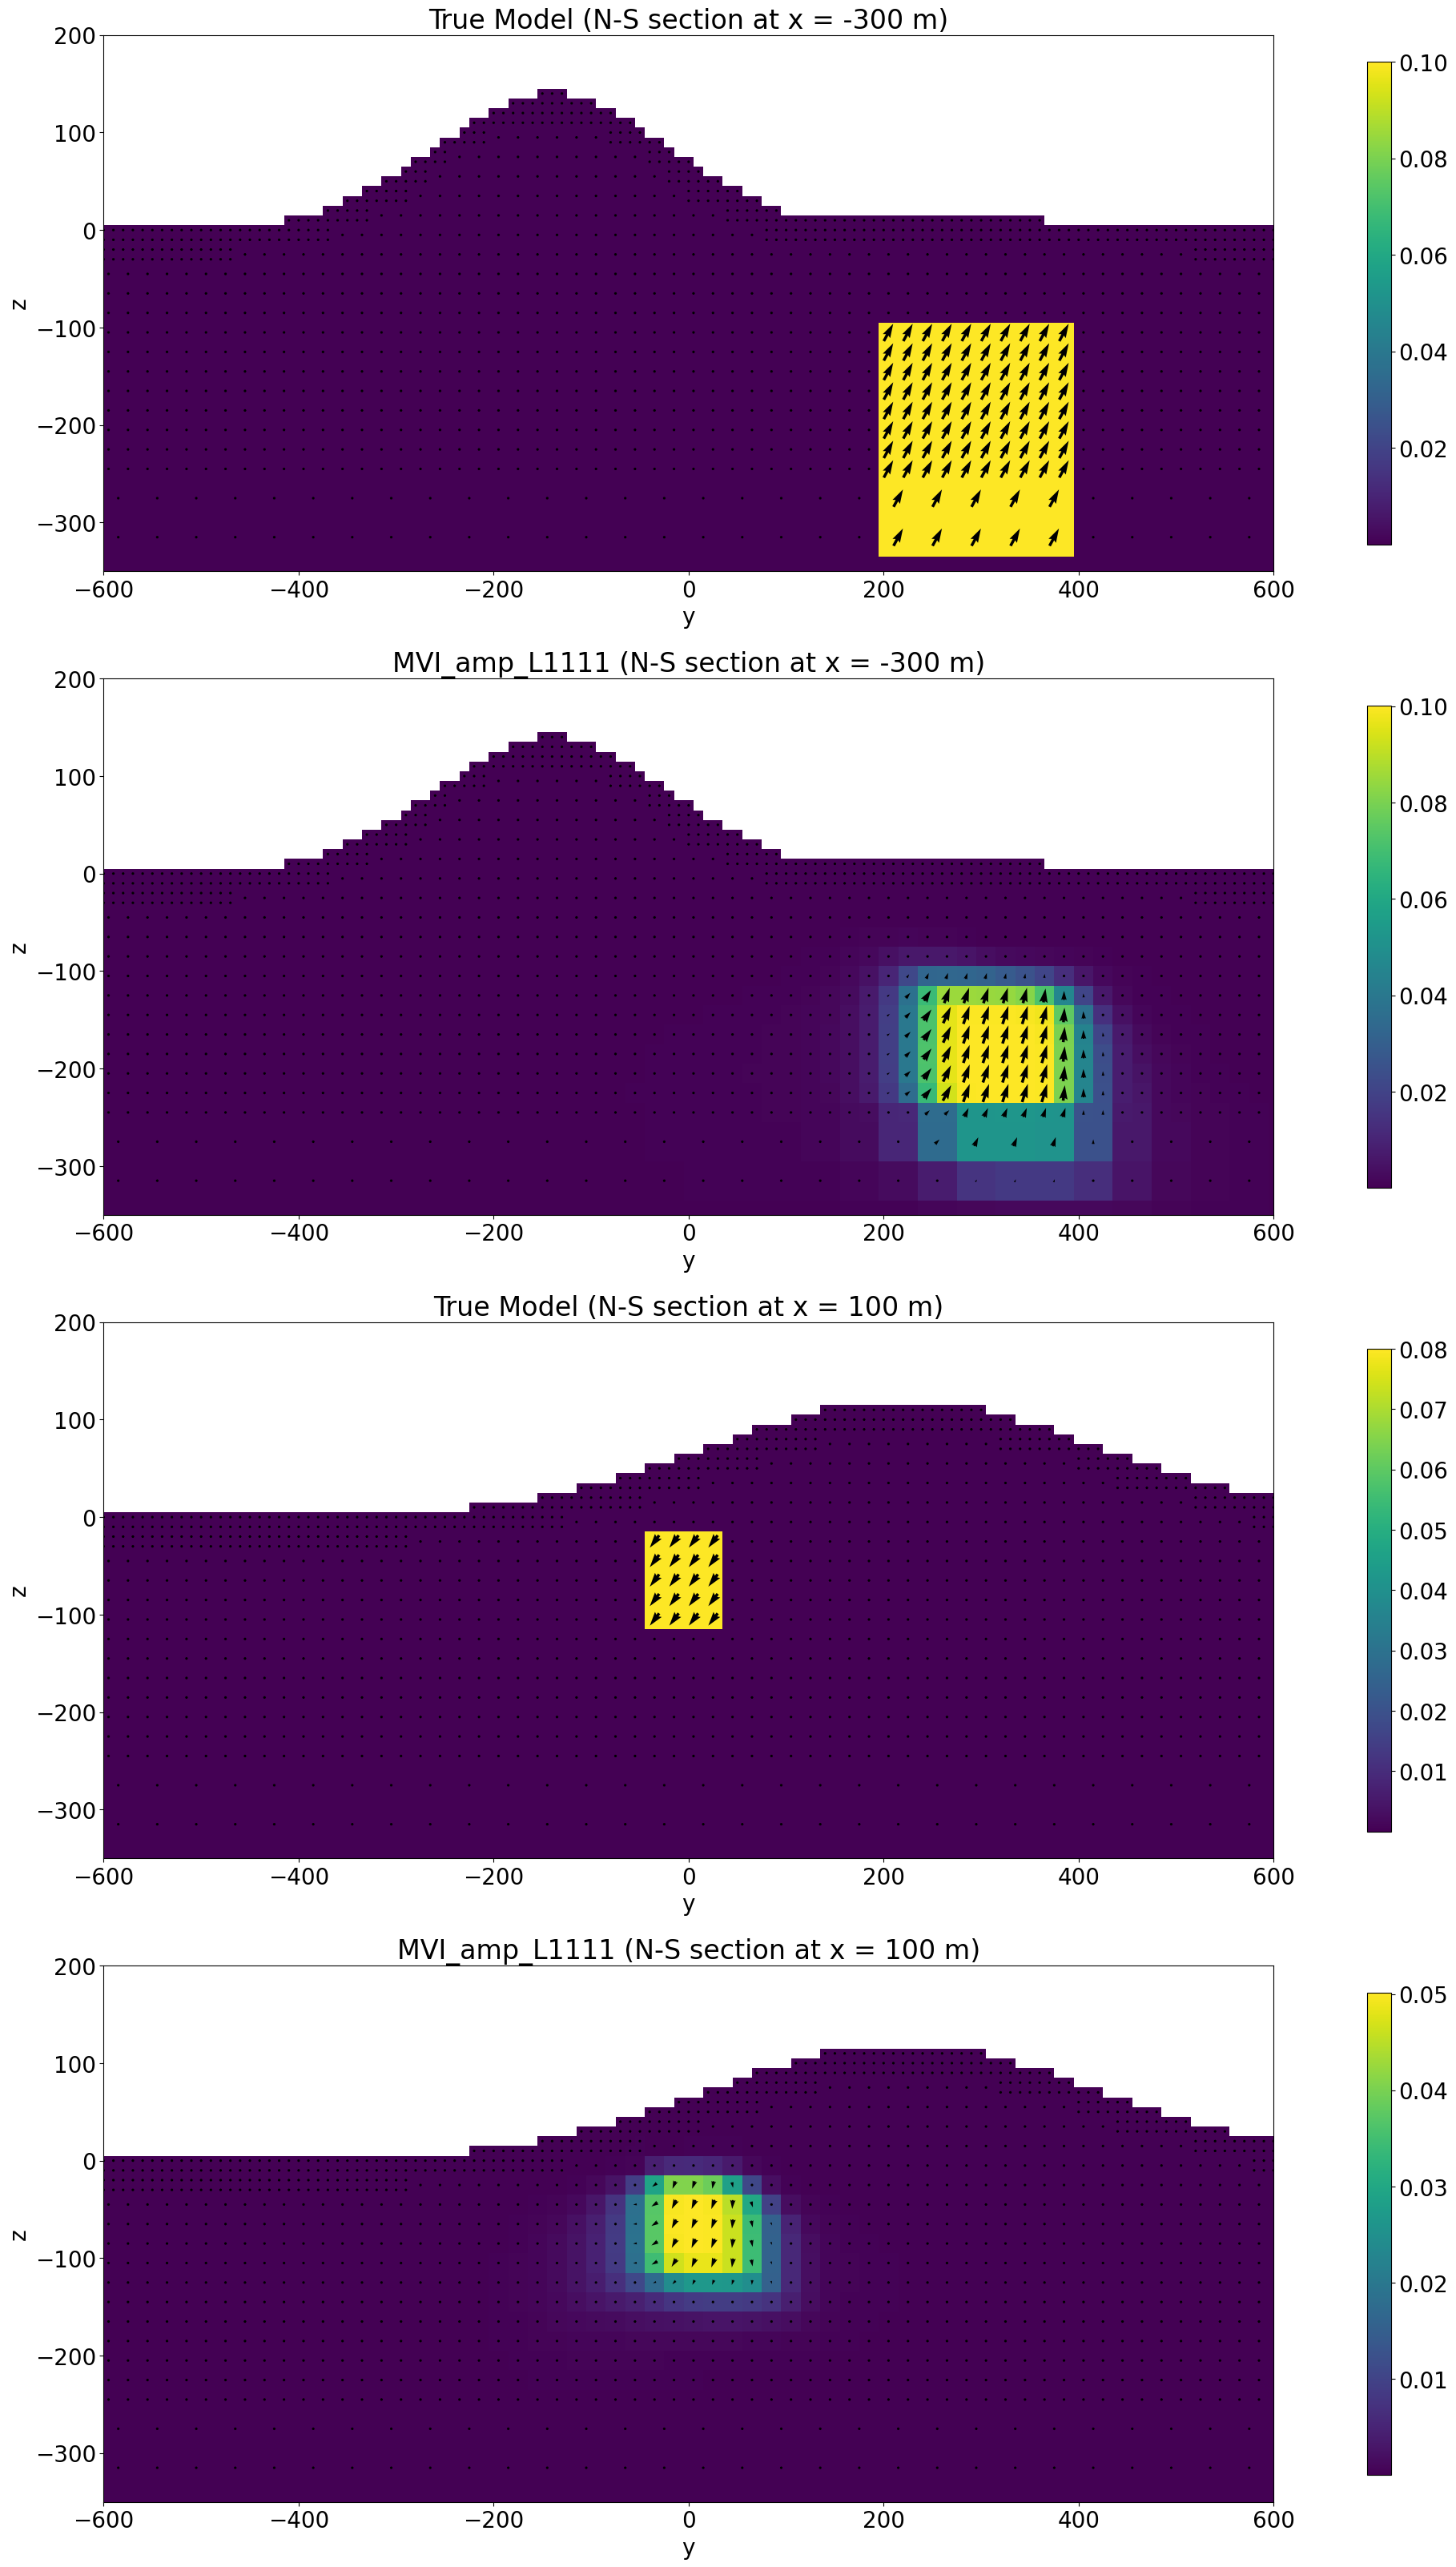

In [62]:
# N-S sections from the synthetic model and the recovered inversion model at x=-300 m and x=100 m
fig = Image(filename=('./mInv_MVI_amp_L1111_xSection_TrueComp.png'))
fig

In [63]:
# # Plot Inversion Results
# z_sliceInd = int(np.searchsorted(mesh.cell_centers_z, -110))
# x_sliceInd = int(np.searchsorted(mesh.cell_centers_x, -300))
# y_sliceInd = int(np.searchsorted(mesh.cell_centers_y, 0))

# plt.figure(figsize=(20,20))

# ax = plt.subplot(3, 2, 1)
# dat1 = plotVectorSectionsOctree(
#         mesh,
#         model,
#         axs=ax,
#         normal="Z",
#         ind=z_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-600, 600])
# ax.set_title("True Model (z = -110 m)")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# plt.colorbar(dat1[0], ax=ax, shrink=1.0)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(3, 2, 2)
# dat2 = plotVectorSectionsOctree(
#         mesh,
#         mInv_MVI_amp.reshape((nActCells, 3), order="F"),
#         axs=ax,
#         normal="Z",
#         ind=z_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-600, 600])
# ax.set_title("MVI_amp_L1111 (z = -110 m)")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# plt.colorbar(dat2[0], ax=ax, shrink=1.0)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(3, 2, 3)
# dat3 = plotVectorSectionsOctree(
#         mesh,
#         model,
#         axs=ax,
#         normal="Y",
#         ind=y_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# ax.set_title('True Model (E-W section at y = 0 m)')
# ax.set_xlabel("x")
# ax.set_ylabel("z")
# plt.colorbar(dat3[0], ax=ax, shrink=0.45)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(3, 2, 4)
# dat4 = plotVectorSectionsOctree(
#         mesh,
#         mInv_MVI_amp.reshape((nActCells, 3), order="F"),
#         axs=ax,
#         normal="Y",
#         ind=y_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# ax.set_title('MVI_amp_L1111 (E-W section at y = 0 m)')
# ax.set_xlabel("x")
# ax.set_ylabel("z")
# plt.colorbar(dat4[0], ax=ax, shrink=0.45)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(3, 2, 5)
# dat3 = plotVectorSectionsOctree(
#         mesh,
#         model,
#         axs=ax,
#         normal="X",
#         ind=x_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# ax.set_title('True Model (N-S section at x = -300 m)')
# ax.set_xlabel("y")
# ax.set_ylabel("z")
# plt.colorbar(dat3[0], ax=ax, shrink=0.45)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(3, 2, 6)
# dat4 = plotVectorSectionsOctree(
#         mesh,
#         mInv_MVI_amp.reshape((nActCells, 3), order="F"),
#         axs=ax,
#         normal="X",
#         ind=x_sliceInd,
#         actCellMap=actCellsMap,
#         scale=0.4,
#         vmin=None,
#         vmax=None)

# ax.set_xlim([-600, 600])
# ax.set_ylim([-350, 200])
# ax.set_title('MVI_amp_L1111 (N-S section at x = -300 m)')
# ax.set_xlabel("y")
# ax.set_ylabel("z")
# plt.colorbar(dat4[0], ax=ax, shrink=0.45)
# plt.gca().set_aspect("equal", adjustable="box")

# plt.savefig("./mInv_MVI_amp_L1111_Tiled_SectionMosaic.png", bbox_inches='tight', orientation='portrait')
# plt.show()



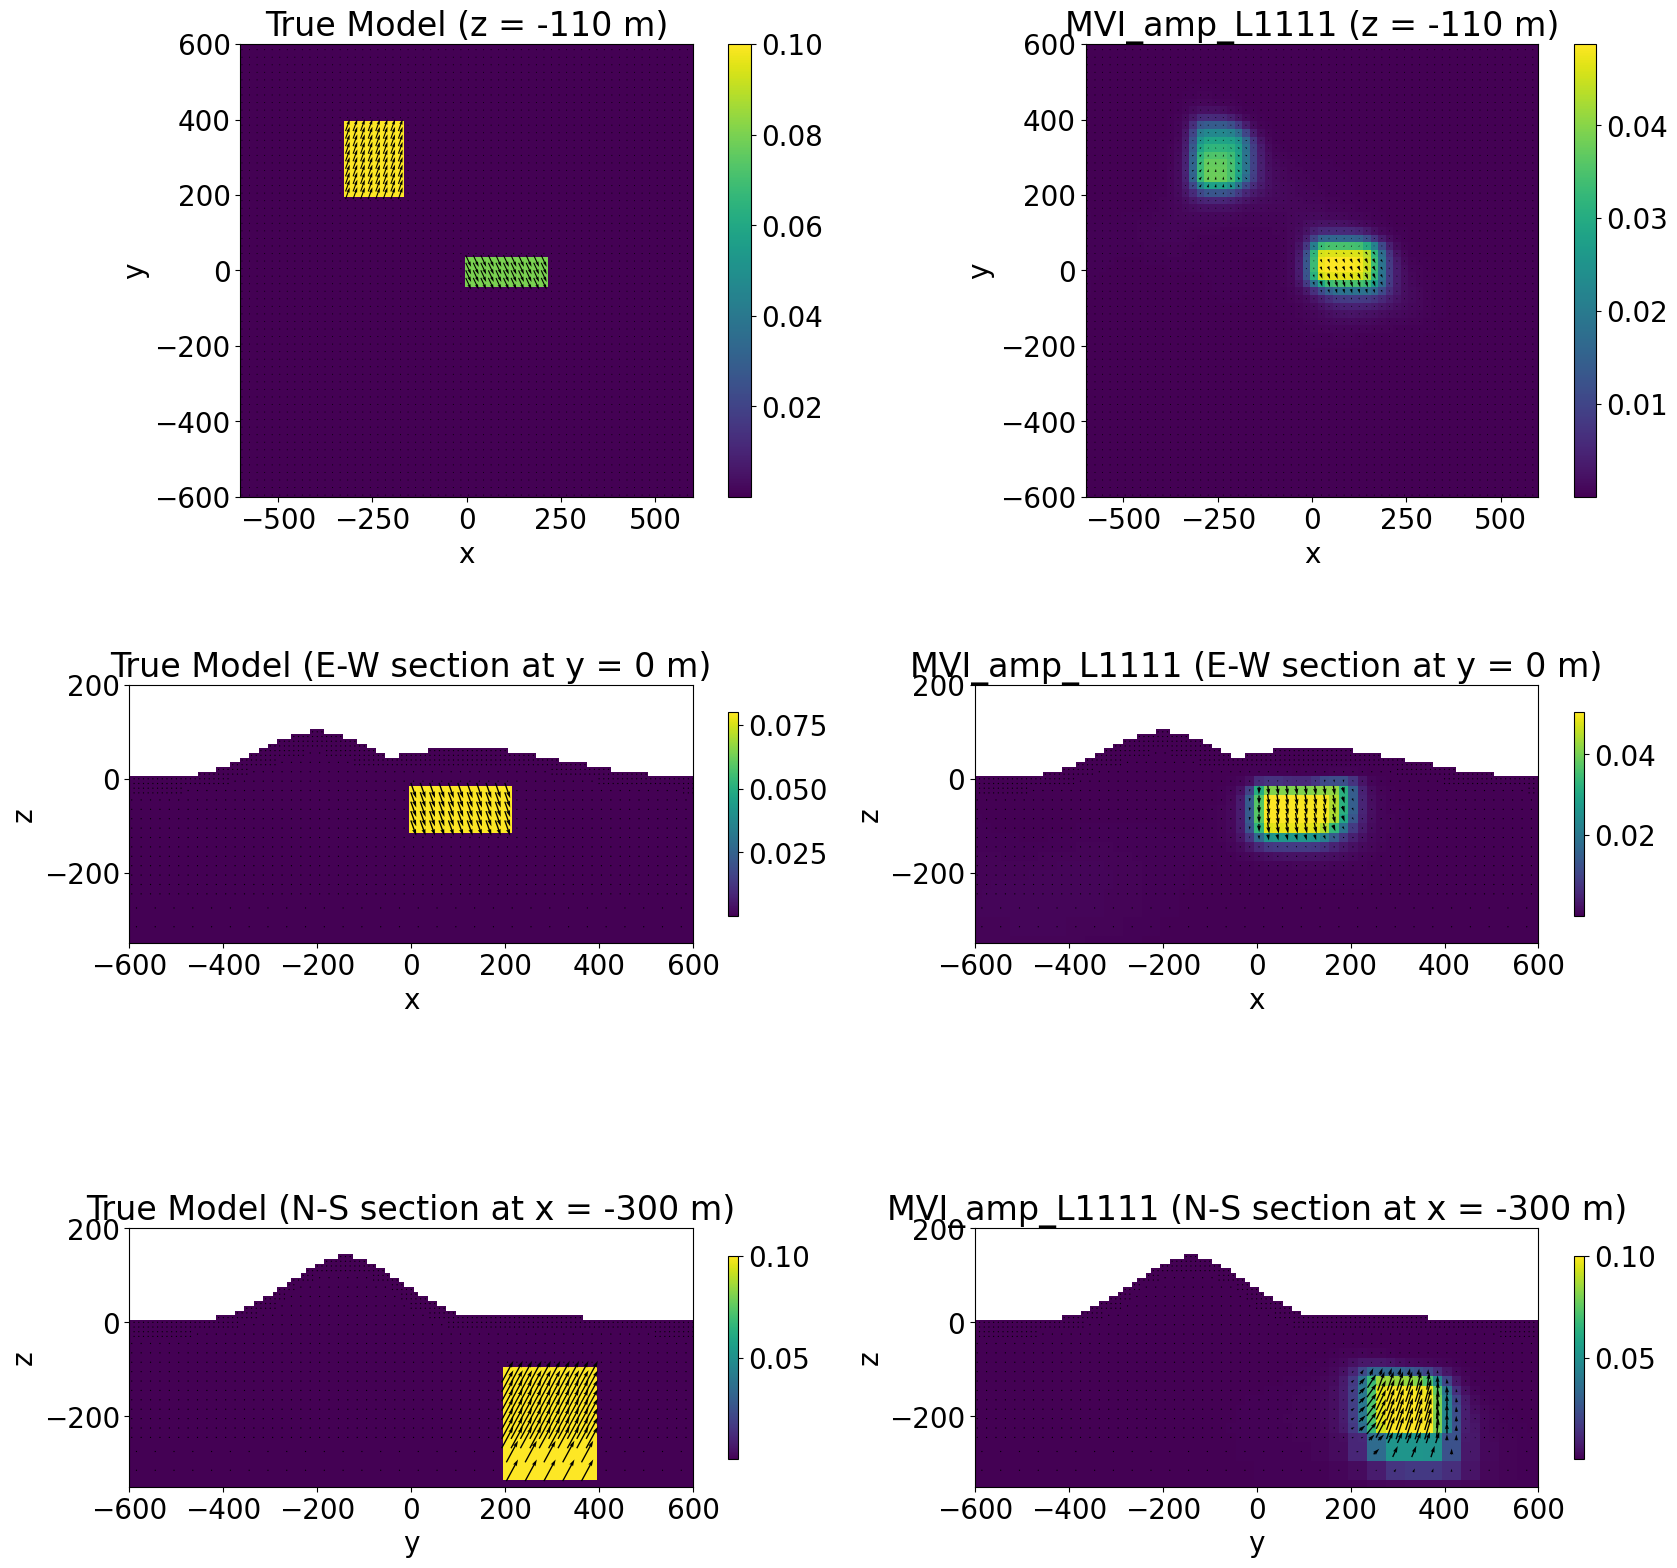

In [64]:
# Multi panel section comparison
fig = Image(filename=('./mInv_MVI_amp_L1111_Tiled_SectionMosaic.png'))
fig

## Plot data and residuals.

In [65]:
# Extract data from each tile and combine them to compare to the full dataset
for ii, local_survey in enumerate(local_surveys):
    if(ii == 0):
        RxLocs_metaSim = local_survey.receiver_locations
    else:
        RxLocs_metaSim = np.vstack([RxLocs_metaSim,local_survey.receiver_locations])
    
print(RxLocs_metaSim.shape)

(625, 3)


In [74]:
# # Plot the final predicted data and the residual
# plt.figure(figsize=(20, 20))

# ax = plt.subplot(2, 2, 1)
# dat1 = utils.plot_utils.plot2Ddata(RxLocs_metaSim, data_metaSim.dobs, ax=ax)
# print(dat1)
# ax.set_title("Observed data")
# plt.colorbar(dat1[0], ax=ax, shrink=0.8)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(2, 2, 2)
# dat2 = utils.plot_utils.plot2Ddata(RxLocs_metaSim, dPred, ax=ax)
# ax.set_title("Predicted data")
# plt.colorbar(dat2[0], ax=ax, shrink=0.8)
# plt.gca().set_aspect("equal", adjustable="box")

# ax = plt.subplot(2, 2, 3)
# dat3 = utils.plot_utils.plot2Ddata(RxLocs_metaSim, data_metaSim.dobs - dPred, ax=ax)
# ax.set_title("Data residuals")
# plt.colorbar(dat3[0], ax=ax, shrink=0.8)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.savefig("./dPred_MVI_amp_L1111_Tiled_Comp.png",bbox_inches='tight', orientation='portrait')

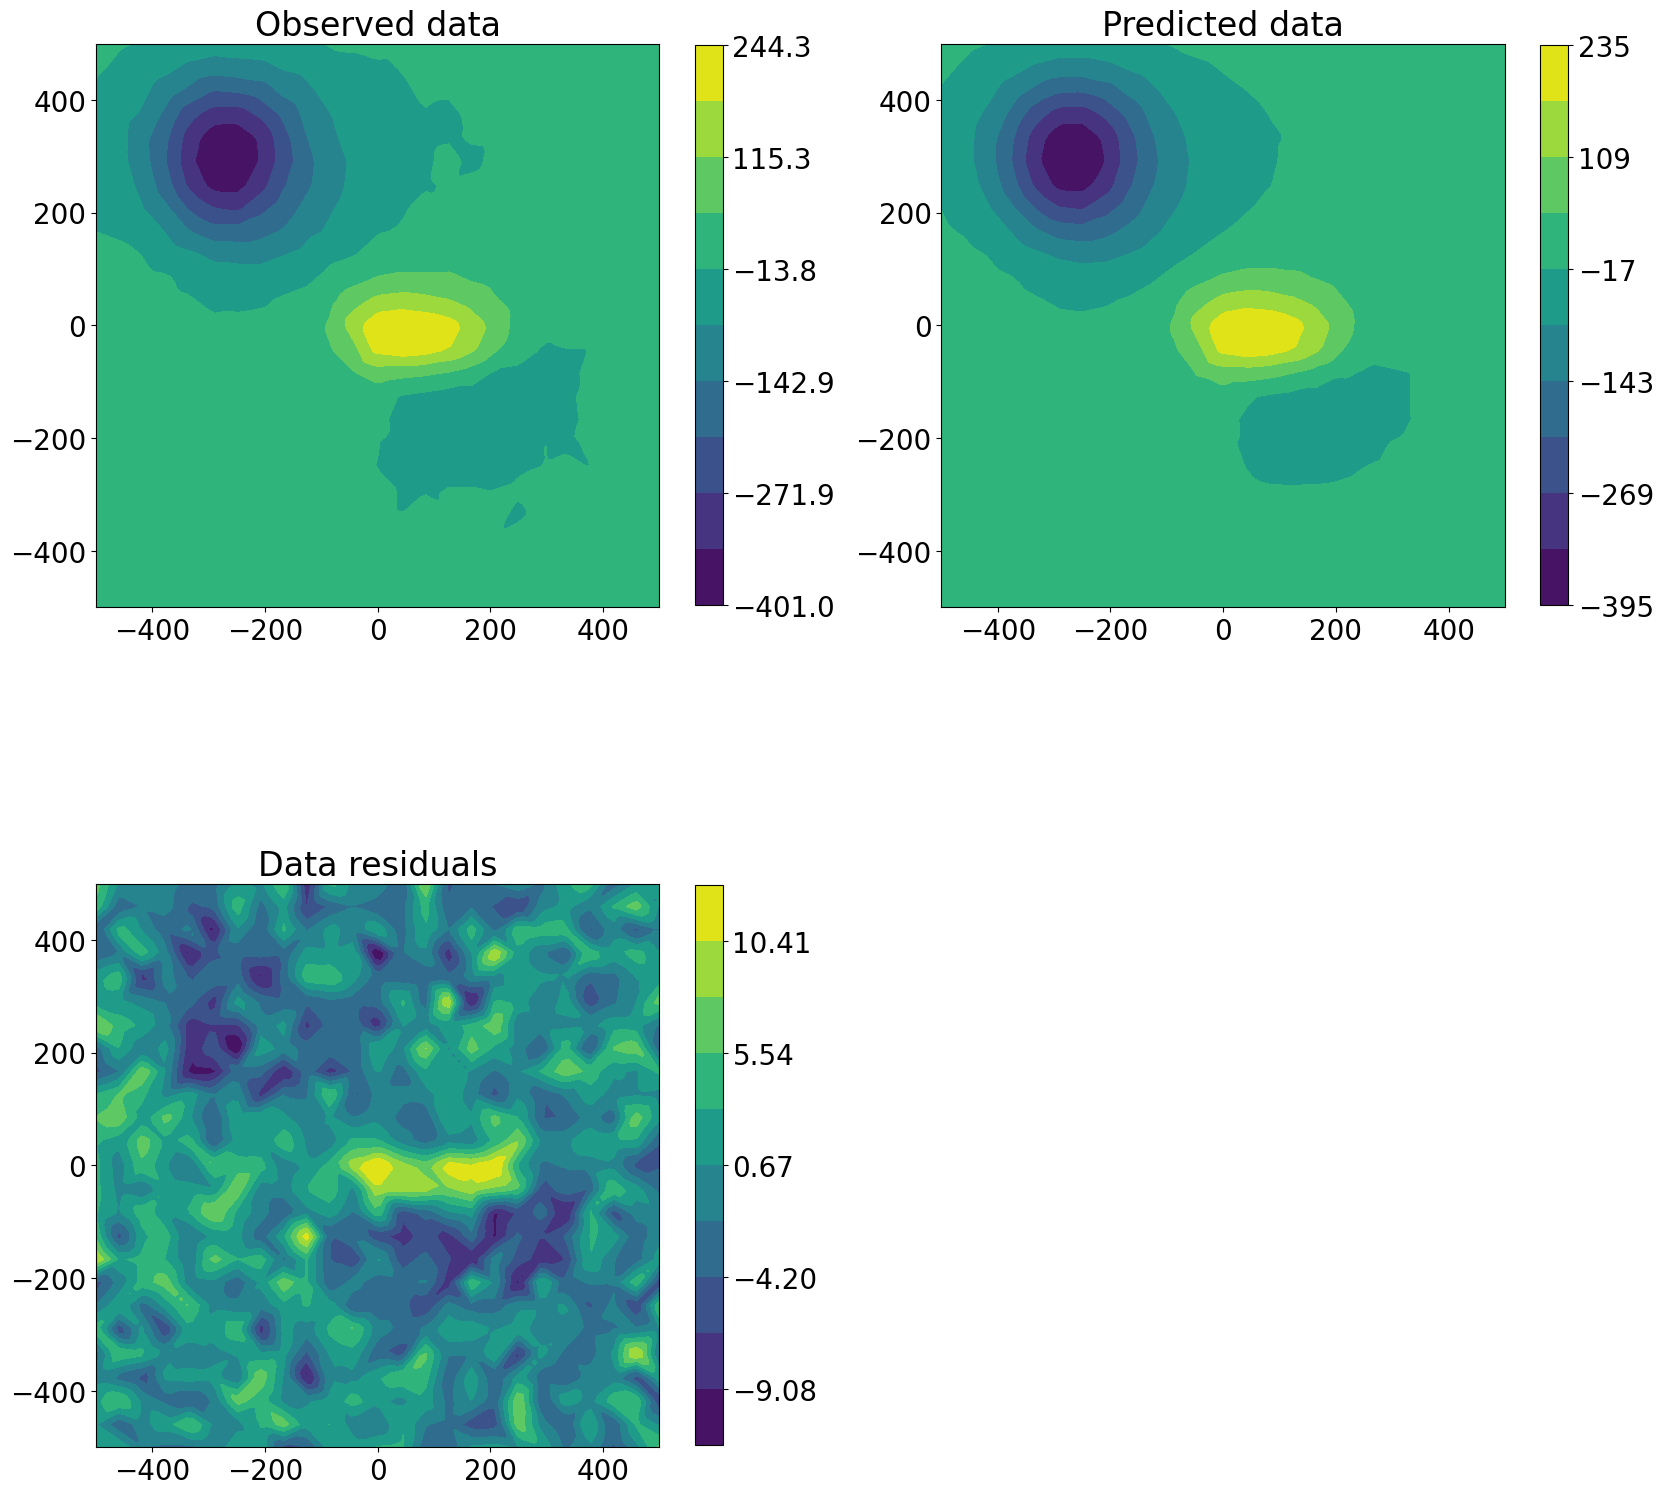

In [75]:
# Compare the synthetic("Observed") data, predicted data from the recovered inverison model, and the residuals.
fig = Image(filename=('./dPred_MVI_amp_L1111_Tiled_Comp.png'))
fig